# Regression Model for all links for Network Rate prediction
This model will predict the values for N_time(time in the network). For N_time prediction, a linear regresion over size/rate is done. Rate information is fetched from fts_aggragated_* index which was previously populated with rate per link per minute.
* import libraries
* create the RSE to site mapping
* get the data
* fit the model
* TODO: test against the data over the next week
* plot plot plot

In [3]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import leastsq,fmin_slsqp, least_squares

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

#### Get AGIS endpoints (RSEs) and site names

In [4]:
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Collect all the links

In [5]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-04-01'  # yyyy-mm-dd
DELTA = 60
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = ['fts_*']
#for i in range(-1, DELTA+1):
#    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
#                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse","transferred_at","submitted_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']] not in data:
        data.append(rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']])
        count += 1
print('Reading',count, 'registers took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK'])

['fts_*']
Reading 9573 registers took 1600.5359947681427 seconds.


In [8]:
links = data
links.values[10]

array(['BNL-ATLAS__INFN-ROMA1'], dtype=object)

In [9]:
def get_data(src,dst):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = '2017-08-01'  # yyyy-mm-dd
    DELTA = 60
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = ['fts_*']
    indexes = ','.join(index_list)
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "src", "dst", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "src" : src }},
                    {"term" : { "dst" : dst }},                    
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([r['src_rse'],r['dst_rse'],rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    print('Reading', count,'registers took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['SRC','DST','LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    return data

def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model

def get_model(link, data, show=False):
    #cut = data.where(data.LINK == link).dropna()
    cut = data
    cut = cut.where(cut.SIZE > 0).dropna()
    cut = cut.where(cut.N_RATE > 0).dropna()
    if len(cut) < 20:
        return link[0],-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf
    vars = [cut.N_RATE.mean(), 1., 100.0]
    try:
        out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
    except ValueError:
        print('Problem on link:', link, '. trying another start')
        try:
            first = cut[cut.SIZE < np.median(cut.SIZE)]
            p1 = np.polyfit(first.SIZE, first.N_RATE,1)
            p1 = np.poly1d(p1)
            secnd = cut[cut.SIZE > np.median(cut.SIZE)]
            p2 = np.polyfit(secnd.SIZE, secnd.N_RATE,1)
            p2 = np.poly1d(p2)
            oini=max(0.01,1/p1.coeffs[0])
            dini=max(0.01,1/p2.coeffs[0])
            vars = [cut.N_RATE.mean(), oini, dini]
            out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
        except ValueError:
            cut = data.sample(int(len(data)*0.5))
            while len(cut) > 20:
                vars = [cut.N_RATE.mean(), 1., 100.0]
                try:
                    out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
                    break
                except ValueError:
                    print('Couldn\'t solve problem for', link,'.  Retrying...')
                    cut = cut.sample(int(len(cut)*0.5))
                    continue
            if len(cut) <= 20:
                print('Couldn\'t solve problem for', link)
                return link[0], -np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,
    rate = out.x[0]
    overhead = out.x[1]
    diskrw = out.x[2]
    #print(link,out)data
    data['N_PRED'] = data.SIZE/((data.SIZE/rate)+overhead)
    data['N_PRED'][data['N_PRED']>diskrw]=diskrw
    cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    datalen = len(cut)
    if show:
        cut = data.set_index(pd.to_datetime(data.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        plt.title('NETWORK rates for %s'%link)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Link Rate in MiB/s')
        plt.ylabel('Transfer rate in MiB/s')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show() 
    return link,r2score, rmse, datalen, rate,overhead,diskrw



In [10]:
link_stats = []
for link in links.values:
    src,dst = link[0].split('__')
    #link = links.values[10][0]
    #src,dst = 'CERN-PROD','BNL-ATLAS'
    print('')
    print(src,'-->',dst)
    data = get_data(src,dst)
    #print(len(data) > 0)
    link_stats.append(get_model(link,data,show=False))


Australia-ATLAS --> INFN-T1
Reading 414 registers took 0.34727001190185547 seconds.


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



RRC-KI-T1 --> Taiwan-LCG2
Reading 1307 registers took 0.48183274269104004 seconds.

FZK-LCG2 --> SWT2_CPB
Reading 16203 registers took 2.7527897357940674 seconds.

MPPMU --> BNL-ATLAS
Reading 877 registers took 0.6955404281616211 seconds.

MWT2 --> GRIF-LAL
Reading 0 registers took 0.18259429931640625 seconds.

CSCS-LCG2 --> MWT2
Reading 4575 registers took 1.1754894256591797 seconds.
Problem on link: ['CSCS-LCG2__MWT2'] . trying another start
Couldn't solve problem for ['CSCS-LCG2__MWT2'] .  Retrying...
Couldn't solve problem for ['CSCS-LCG2__MWT2'] .  Retrying...


/usr/lib64/python3.4/site-packages/scipy/optimize/_lsq/common.py:425: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x
/usr/lib64/python3.4/site-packages/scipy/optimize/_lsq/common.py:431: RuntimeWarning: invalid value encountered in less_equal
  (lower_dist <= np.minimum(upper_dist, lower_threshold)))
/usr/lib64/python3.4/site-packages/scipy/optimize/_lsq/common.py:435: RuntimeWarning: invalid value encountered in less_equal
  (upper_dist <= np.minimum(lower_dist, upper_threshold)))



BNL-ATLAS --> INFN-T1
Reading 5723 registers took 1.0747480392456055 seconds.

SARA-MATRIX --> INFN-T1
Reading 1082 registers took 0.6673376560211182 seconds.

TOKYO-LCG2 --> SWT2_CPB
Reading 4680 registers took 0.8916916847229004 seconds.

RAL-LCG2 --> RRC-KI-T1
Reading 7877 registers took 1.399021863937378 seconds.

BNL-ATLAS --> INFN-ROMA1
Reading 2324 registers took 0.6263272762298584 seconds.

RAL-LCG2-ECHO --> IFIC-LCG2
Reading 0 registers took 0.2308940887451172 seconds.

RAL-LCG2 --> CSCS-LCG2
Reading 10455 registers took 1.3698632717132568 seconds.
Problem on link: ['RAL-LCG2__CSCS-LCG2'] . trying another start

CA-MCGILL-CLUMEQ-T2 --> MWT2
Reading 641 registers took 0.568495512008667 seconds.

AGLT2 --> UNI-FREIBURG
Reading 1015 registers took 0.40674924850463867 seconds.

CERN-PROD --> BNL-ATLAS
Reading 198356 registers took 22.822798013687134 seconds.
Problem on link: ['CERN-PROD__BNL-ATLAS'] . trying another start
Couldn't solve problem for ['CERN-PROD__BNL-ATLAS'] .  Ret

Reading 2617 registers took 0.522282600402832 seconds.

CSCS-LCG2 --> LRZ-LMU
Reading 863 registers took 0.25693774223327637 seconds.

INFN-T1 --> UKI-LT2-QMUL
Reading 6713 registers took 0.8097116947174072 seconds.
Problem on link: ['INFN-T1__UKI-LT2-QMUL'] . trying another start
Couldn't solve problem for ['INFN-T1__UKI-LT2-QMUL'] .  Retrying...
Couldn't solve problem for ['INFN-T1__UKI-LT2-QMUL'] .  Retrying...

NDGF-T1 --> RRC-KI-T1
Reading 12307 registers took 1.6248128414154053 seconds.
Problem on link: ['NDGF-T1__RRC-KI-T1'] . trying another start
Couldn't solve problem for ['NDGF-T1__RRC-KI-T1'] .  Retrying...
Couldn't solve problem for ['NDGF-T1__RRC-KI-T1'] .  Retrying...
Couldn't solve problem for ['NDGF-T1__RRC-KI-T1'] .  Retrying...

DESY-HH --> RAL-LCG2
Reading 2881 registers took 0.45082712173461914 seconds.
Problem on link: ['DESY-HH__RAL-LCG2'] . trying another start
Couldn't solve problem for ['DESY-HH__RAL-LCG2'] .  Retrying...
Couldn't solve problem for ['DESY-HH__R

Reading 8194 registers took 1.3385803699493408 seconds.
Problem on link: ['IN2P3-CC__MPPMU'] . trying another start
Couldn't solve problem for ['IN2P3-CC__MPPMU'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__MPPMU'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__MPPMU'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__MPPMU'] .  Retrying...

FZK-LCG2 --> CERN-PROD
Reading 25396 registers took 3.3299434185028076 seconds.
Problem on link: ['FZK-LCG2__CERN-PROD'] . trying another start
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['FZK-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['

Reading 22705 registers took 2.6933789253234863 seconds.
Problem on link: ['SWT2_CPB__BNL-ATLAS'] . trying another start
Couldn't solve problem for ['SWT2_CPB__BNL-ATLAS'] .  Retrying...
Couldn't solve problem for ['SWT2_CPB__BNL-ATLAS'] .  Retrying...
Couldn't solve problem for ['SWT2_CPB__BNL-ATLAS'] .  Retrying...

IFIC-LCG2 --> INFN-T1
Reading 193 registers took 0.1536712646484375 seconds.

BU_ATLAS_Tier2 --> RRC-KI-T1
Reading 158 registers took 0.13884329795837402 seconds.

TOKYO-LCG2 --> NDGF-T1
Reading 7204 registers took 1.354546308517456 seconds.

WT2 --> NDGF-T1
Reading 3020 registers took 0.5056047439575195 seconds.

FZK-LCG2 --> ifae
Reading 14973 registers took 1.47153639793396 seconds.
Problem on link: ['FZK-LCG2__ifae'] . trying another start
Couldn't solve problem for ['FZK-LCG2__ifae'] .  Retrying...

RAL-LCG2 --> UKI-SCOTGRID-GLASGOW
Reading 10088 registers took 1.0587844848632812 seconds.
Problem on link: ['RAL-LCG2__UKI-SCOTGRID-GLASGOW'] . trying another start
Coul


DESY-HH --> CERN-PROD
Reading 10297 registers took 1.234269380569458 seconds.
Problem on link: ['DESY-HH__CERN-PROD'] . trying another start
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['DESY-HH__CERN-PROD'] .  Retrying...

TOKYO-LCG2 --> IL-TAU-HEP
Reading 343 registers took 0.5908751487731934 seconds.

UNI-FREIBURG --> INFN-T1
Reading 122 registers took 0.32270121574401855 seconds.

RAL-LCG2 --> UKI-NORTHGRID-LANCS-HEP
Reading 24862 registers took 3.221879243850708 seconds.

BNL-ATLAS --> EELA-UTFSM
Reading 1838 registers took 0.8618605136871338 seconds.

UKI-LT2-QMUL --> CSCS-LCG2
Reading 4753 registers took 0.49440


BU_ATLAS_Tier2 --> INFN-COSENZA
Reading 301 registers took 0.25467944145202637 seconds.

Taiwan-LCG2 --> UKI-NORTHGRID-SHEF-HEP
Reading 6207 registers took 0.910635232925415 seconds.

SWT2_CPB --> AGLT2
Reading 8226 registers took 0.8705320358276367 seconds.

SARA-MATRIX --> UKI-SCOTGRID-GLASGOW
Reading 3262 registers took 0.5260603427886963 seconds.

NDGF-T1 --> IN2P3-LAPP
Reading 7230 registers took 1.0740265846252441 seconds.

SWT2_CPB --> INFN-NAPOLI-ATLAS
Reading 3901 registers took 0.5091004371643066 seconds.

RO-07-NIPNE --> RO-02-NIPNE
Reading 708 registers took 0.23885726928710938 seconds.

IN2P3-CC --> BEIJING-LCG2
Reading 864 registers took 0.5534546375274658 seconds.

Taiwan-LCG2 --> RAL-LCG2
Reading 10527 registers took 1.845029354095459 seconds.

TRIUMF-LCG2 --> INFN-T1
Reading 2088 registers took 0.7809538841247559 seconds.

DESY-HH --> MWT2
Reading 3909 registers took 0.5737183094024658 seconds.
Problem on link: ['DESY-HH__MWT2'] . trying another start

TOKYO-LCG2 --> 


UKI-LT2-QMUL --> UKI-NORTHGRID-LIV-HEP
Reading 1081 registers took 0.6392343044281006 seconds.

UKI-LT2-QMUL --> UKI-NORTHGRID-LANCS-HEP
Reading 2352 registers took 0.5370702743530273 seconds.

RAL-LCG2 --> NERSC-PDSF
Reading 706 registers took 0.563075065612793 seconds.

TOKYO-LCG2 --> RO-02-NIPNE
Reading 357 registers took 0.5740311145782471 seconds.

BNL-ATLAS --> FZK-LCG2
Reading 13348 registers took 1.8108630180358887 seconds.
Problem on link: ['BNL-ATLAS__FZK-LCG2'] . trying another start
Couldn't solve problem for ['BNL-ATLAS__FZK-LCG2'] .  Retrying...
Couldn't solve problem for ['BNL-ATLAS__FZK-LCG2'] .  Retrying...

wuppertalprod --> BNL-ATLAS
Reading 1701 registers took 0.2695596218109131 seconds.

RO-07-NIPNE --> TRIUMF-LCG2
Reading 190 registers took 0.37793707847595215 seconds.

NIKHEF-ELPROD --> BNL-ATLAS
Reading 10166 registers took 1.5452556610107422 seconds.
Problem on link: ['NIKHEF-ELPROD__BNL-ATLAS'] . trying another start

CERN-PROD --> pic
Reading 64242 registers


RRC-KI-T1 --> LRZ-LMU
Reading 488 registers took 0.18335485458374023 seconds.

CA-MCGILL-CLUMEQ-T2 --> SARA-MATRIX
Reading 59 registers took 0.28471827507019043 seconds.

WT2 --> GRIF-LAL
Reading 0 registers took 0.14984774589538574 seconds.

BNL-ATLAS --> RAL-LCG2
Reading 14768 registers took 2.0646462440490723 seconds.

FZK-LCG2 --> wuppertalprod
Reading 1774 registers took 0.5706431865692139 seconds.
Problem on link: ['FZK-LCG2__wuppertalprod'] . trying another start
Couldn't solve problem for ['FZK-LCG2__wuppertalprod'] .  Retrying...

UKI-LT2-QMUL --> CERN-PROD
Reading 11542 registers took 1.1443731784820557 seconds.

MPPMU --> INFN-T1
Reading 104 registers took 0.16873860359191895 seconds.

WT2 --> UKI-LT2-RHUL
Reading 1760 registers took 0.5500929355621338 seconds.

praguelcg2 --> DESY-ZN
Reading 1582 registers took 0.258669376373291 seconds.

LRZ-LMU --> BU_ATLAS_Tier2
Reading 1579 registers took 0.37409496307373047 seconds.

CERN-PROD --> UKI-NORTHGRID-LIV-HEP
Reading 3783 re


MWT2 --> CA-SCINET-T2
Reading 4346 registers took 0.6009573936462402 seconds.
Problem on link: ['MWT2__CA-SCINET-T2'] . trying another start

BU_ATLAS_Tier2 --> GRIF-LAL
Reading 0 registers took 0.11289787292480469 seconds.

RAL-LCG2 --> IN2P3-LAPP
Reading 4139 registers took 0.7144455909729004 seconds.

MWT2 --> RRC-KI-T1
Reading 129611 registers took 13.96801233291626 seconds.
Problem on link: ['MWT2__RRC-KI-T1'] . trying another start
Couldn't solve problem for ['MWT2__RRC-KI-T1'] .  Retrying...

UKI-LT2-QMUL --> IFIC-LCG2
Reading 1175 registers took 0.5649566650390625 seconds.

SARA-MATRIX --> UKI-LT2-QMUL
Reading 1230 registers took 0.528780460357666 seconds.

GRIF-IRFU --> TOKYO-LCG2
Reading 0 registers took 0.06969213485717773 seconds.

TRIUMF-LCG2 --> IFIC-LCG2
Reading 2746 registers took 0.6189961433410645 seconds.

praguelcg2 --> UKI-LT2-QMUL
Reading 1653 registers took 0.3301217555999756 seconds.

SWT2_CPB --> UKI-SCOTGRID-GLASGOW
Reading 17176 registers took 1.762169599533


SWT2_CPB --> DESY-ZN
Reading 5382 registers took 0.6040680408477783 seconds.

BNL-ATLAS --> AGLT2
Reading 58984 registers took 6.507256984710693 seconds.
Problem on link: ['BNL-ATLAS__AGLT2'] . trying another start
Couldn't solve problem for ['BNL-ATLAS__AGLT2'] .  Retrying...
Couldn't solve problem for ['BNL-ATLAS__AGLT2'] .  Retrying...
Couldn't solve problem for ['BNL-ATLAS__AGLT2'] .  Retrying...
Couldn't solve problem for ['BNL-ATLAS__AGLT2'] .  Retrying...
Couldn't solve problem for ['BNL-ATLAS__AGLT2'] .  Retrying...

CERN-PROD --> Taiwan-LCG2
Reading 27212 registers took 3.3616271018981934 seconds.

INFN-T1 --> RAL-LCG2
Reading 14087 registers took 1.4390826225280762 seconds.

LRZ-LMU --> RAL-LCG2
Reading 2318 registers took 0.3871452808380127 seconds.
Problem on link: ['LRZ-LMU__RAL-LCG2'] . trying another start

INFN-T1 --> pic
Reading 5565 registers took 0.8394570350646973 seconds.
Problem on link: ['INFN-T1__pic'] . trying another start

Taiwan-LCG2 --> AGLT2
Reading 4232 

Reading 1599 registers took 0.5445261001586914 seconds.

LRZ-LMU --> praguelcg2
Reading 2944 registers took 0.4481368064880371 seconds.

SARA-MATRIX --> BU_ATLAS_Tier2
Reading 2899 registers took 0.4595210552215576 seconds.

AGLT2 --> LRZ-LMU
Reading 11182 registers took 1.5692181587219238 seconds.

TRIUMF-LCG2 --> CA-MCGILL-CLUMEQ-T2
Reading 5766 registers took 0.7173004150390625 seconds.
Problem on link: ['TRIUMF-LCG2__CA-MCGILL-CLUMEQ-T2'] . trying another start

TRIUMF-LCG2 --> AGLT2
Reading 13930 registers took 1.3997042179107666 seconds.
Problem on link: ['TRIUMF-LCG2__AGLT2'] . trying another start

IN2P3-CC --> WT2
Reading 4416 registers took 0.5655093193054199 seconds.

WT2 --> IN2P3-CC
Reading 1558 registers took 0.512786865234375 seconds.

LRZ-LMU --> INFN-NAPOLI-ATLAS
Reading 4459 registers took 1.1498498916625977 seconds.

praguelcg2 --> GRIF-LAL
Reading 0 registers took 0.09587502479553223 seconds.

INFN-NAPOLI-ATLAS --> Australia-ATLAS
Reading 200 registers took 0.379466

Reading 46 registers took 0.23967432975769043 seconds.

UKI-NORTHGRID-LIV-HEP --> IFIC-LCG2
Reading 71 registers took 0.4910130500793457 seconds.

RRC-KI-T1 --> SWT2_CPB
Reading 2148 registers took 0.37286829948425293 seconds.

DESY-ZN --> UKI-NORTHGRID-MAN-HEP
Reading 336 registers took 0.4263334274291992 seconds.

INFN-NAPOLI-ATLAS --> GoeGrid
Reading 547 registers took 0.4574251174926758 seconds.

IN2P3-CC --> INFN-MILANO-ATLASC
Reading 6554 registers took 1.1933114528656006 seconds.
Problem on link: ['IN2P3-CC__INFN-MILANO-ATLASC'] . trying another start

IN2P3-CC --> ifae
Reading 8585 registers took 1.077458381652832 seconds.
Problem on link: ['IN2P3-CC__ifae'] . trying another start

FZK-LCG2 --> INFN-ROMA1
Reading 1811 registers took 0.3067898750305176 seconds.

NDGF-T1 --> IN2P3-CPPM
Reading 6017 registers took 0.6180188655853271 seconds.

MWT2 --> RAL-LCG2
Reading 56923 registers took 11.838271617889404 seconds.
Problem on link: ['MWT2__RAL-LCG2'] . trying another start
Couldn


Taiwan-LCG2 --> UKI-NORTHGRID-LANCS-HEP
Reading 4242 registers took 0.7224113941192627 seconds.

GRIF-IRFU --> IFIC-LCG2
Reading 0 registers took 0.163618803024292 seconds.

MPPMU --> AGLT2
Reading 889 registers took 0.35654687881469727 seconds.

DESY-HH --> RRC-KI-T1
Reading 2514 registers took 0.485013484954834 seconds.

AGLT2 --> GRIF-IRFU
Reading 0 registers took 0.4160749912261963 seconds.

UKI-LT2-RHUL --> Australia-ATLAS
Reading 229 registers took 0.18811583518981934 seconds.

WT2 --> Australia-ATLAS
Reading 1934 registers took 0.3468611240386963 seconds.

ifae --> DESY-HH
Reading 865 registers took 0.5061492919921875 seconds.

NIKHEF-ELPROD --> INFN-T1
Reading 1364 registers took 0.5492315292358398 seconds.

NIKHEF-ELPROD --> UKI-SCOTGRID-GLASGOW
Reading 12659 registers took 1.5867719650268555 seconds.
Problem on link: ['NIKHEF-ELPROD__UKI-SCOTGRID-GLASGOW'] . trying another start
Couldn't solve problem for ['NIKHEF-ELPROD__UKI-SCOTGRID-GLASGOW'] .  Retrying...
Couldn't solve 


RAL-LCG2 --> UKI-LT2-QMUL
Reading 10320 registers took 1.3315222263336182 seconds.

UKI-SCOTGRID-GLASGOW --> SWT2_CPB
Reading 1394 registers took 0.5268337726593018 seconds.

INFN-T1 --> UKI-SCOTGRID-GLASGOW
Reading 10021 registers took 0.9944512844085693 seconds.

NDGF-T1 --> SARA-MATRIX
Reading 3746 registers took 0.5117156505584717 seconds.

Taiwan-LCG2 --> CERN-PROD
Reading 10525 registers took 1.2775099277496338 seconds.
Problem on link: ['Taiwan-LCG2__CERN-PROD'] . trying another start
Couldn't solve problem for ['Taiwan-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['Taiwan-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['Taiwan-LCG2__CERN-PROD'] .  Retrying...

praguelcg2 --> CA-VICTORIA-WESTGRID-T2
Reading 735 registers took 0.46335840225219727 seconds.

GRIF-LAL --> UKI-LT2-QMUL
Reading 0 registers took 0.09005069732666016 seconds.

UKI-LT2-QMUL --> UKI-SCOTGRID-ECDF
Reading 3700 registers took 0.8185296058654785 seconds.

INFN-COSENZA --> RAL-LCG2


UKI-NORTHGRID-MAN-HEP --> IFIC-LCG2
Reading 680 registers took 0.5943143367767334 seconds.

UKI-LT2-QMUL --> RAL-LCG2
Reading 2889 registers took 0.5877900123596191 seconds.

SWT2_CPB --> UKI-NORTHGRID-LANCS-HEP
Reading 8091 registers took 1.100944995880127 seconds.

SARA-MATRIX --> WT2
Reading 831 registers took 0.5293488502502441 seconds.

UKI-NORTHGRID-MAN-HEP --> DESY-ZN
Reading 1855 registers took 0.5425980091094971 seconds.

IN2P3-LPSC --> Australia-ATLAS
Reading 115 registers took 0.13611507415771484 seconds.

IN2P3-CC --> GoeGrid
Reading 3596 registers took 0.6320106983184814 seconds.
Problem on link: ['IN2P3-CC__GoeGrid'] . trying another start
Couldn't solve problem for ['IN2P3-CC__GoeGrid'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__GoeGrid'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__GoeGrid'] .  Retrying...

pic --> INFN-MILANO-ATLASC
Reading 6842 registers took 0.7434096336364746 seconds.

AGLT2 --> GoeGrid
Reading 2809 registers took 0.522925138473

Reading 76 registers took 0.3945128917694092 seconds.

BU_ATLAS_Tier2 --> MWT2
Reading 16039 registers took 2.1384692192077637 seconds.
Problem on link: ['BU_ATLAS_Tier2__MWT2'] . trying another start
Couldn't solve problem for ['BU_ATLAS_Tier2__MWT2'] .  Retrying...
Couldn't solve problem for ['BU_ATLAS_Tier2__MWT2'] .  Retrying...

INFN-T1 --> UNIBE-LHEP
Reading 4025 registers took 0.5809638500213623 seconds.

FZK-LCG2 --> UKI-SCOTGRID-ECDF
Reading 3545 registers took 0.9092004299163818 seconds.
Problem on link: ['FZK-LCG2__UKI-SCOTGRID-ECDF'] . trying another start

IN2P3-CC --> IN2P3-LAPP
Reading 3732 registers took 0.5562853813171387 seconds.
Problem on link: ['IN2P3-CC__IN2P3-LAPP'] . trying another start
Couldn't solve problem for ['IN2P3-CC__IN2P3-LAPP'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__IN2P3-LAPP'] .  Retrying...

Australia-ATLAS --> CA-SCINET-T2
Reading 104 registers took 0.15114045143127441 seconds.

BEIJING-LCG2 --> INFN-T1
Reading 332 registers took 0.


INFN-T1 --> NDGF-T1
Reading 7474 registers took 0.9523055553436279 seconds.

TRIUMF-LCG2 --> IL-TAU-HEP
Reading 4386 registers took 0.6536846160888672 seconds.

GRIF-IRFU --> DESY-ZN
Reading 0 registers took 0.13794445991516113 seconds.

RRC-KI-T1 --> INFN-MILANO-ATLASC
Reading 132 registers took 0.3404538631439209 seconds.

BNL-ATLAS --> CA-SCINET-T2
Reading 21936 registers took 2.502897024154663 seconds.
Problem on link: ['BNL-ATLAS__CA-SCINET-T2'] . trying another start
Couldn't solve problem for ['BNL-ATLAS__CA-SCINET-T2'] .  Retrying...
Couldn't solve problem for ['BNL-ATLAS__CA-SCINET-T2'] .  Retrying...

INFN-T1 --> AGLT2
Reading 31085 registers took 3.5197067260742188 seconds.

pic --> CA-SCINET-T2
Reading 210 registers took 0.13941287994384766 seconds.

MWT2 --> SFU-LCG2
Reading 565 registers took 0.19671177864074707 seconds.
Problem on link: ['MWT2__SFU-LCG2'] . trying another start
Couldn't solve problem for ['MWT2__SFU-LCG2'] .  Retrying...
Couldn't solve problem for ['MWT

Reading 3020 registers took 0.7117867469787598 seconds.

NIKHEF-ELPROD --> AGLT2
Reading 10247 registers took 1.5954160690307617 seconds.

UKI-SOUTHGRID-OX-HEP --> IFIC-LCG2
Reading 134 registers took 0.11365890502929688 seconds.

GRIF-LAL --> TRIUMF-LCG2
Reading 0 registers took 0.09698867797851562 seconds.

AGLT2 --> Australia-ATLAS
Reading 4029 registers took 0.4444293975830078 seconds.

LRZ-LMU --> DESY-ZN
Reading 1790 registers took 0.2606322765350342 seconds.

MWT2 --> INFN-COSENZA
Reading 2243 registers took 0.32837724685668945 seconds.

SARA-MATRIX --> RAL-LCG2-ECHO
Reading 0 registers took 0.10319232940673828 seconds.

NDGF-T1 --> GRIF-IRFU
Reading 0 registers took 0.3831171989440918 seconds.

NDGF-T1 --> RAL-LCG2-ECHO
Reading 0 registers took 0.22234463691711426 seconds.

Australia-ATLAS --> UKI-SCOTGRID-ECDF
Reading 202 registers took 0.22214889526367188 seconds.

INFN-MILANO-ATLASC --> TRIUMF-LCG2
Reading 351 registers took 0.2779879570007324 seconds.

CA-SCINET-T2 --> BU_A

Couldn't solve problem for ['MWT2__IL-TAU-HEP'] .  Retrying...
Couldn't solve problem for ['MWT2__IL-TAU-HEP'] .  Retrying...

INFN-ROMA1 --> DESY-HH
Reading 825 registers took 0.23828530311584473 seconds.

UKI-LT2-RHUL --> RAL-LCG2
Reading 673 registers took 0.4351320266723633 seconds.

GRIF-LPNHE --> NDGF-T1
Reading 0 registers took 0.13451886177062988 seconds.

NIKHEF-ELPROD --> INFN-MILANO-ATLASC
Reading 1664 registers took 0.49310731887817383 seconds.

RAL-LCG2 --> RU-Protvino-IHEP
Reading 2604 registers took 0.446089506149292 seconds.

SARA-MATRIX --> NDGF-T1
Reading 734 registers took 0.24506831169128418 seconds.

CERN-PROD --> praguelcg2
Reading 22258 registers took 3.0382704734802246 seconds.
Problem on link: ['CERN-PROD__praguelcg2'] . trying another start
Couldn't solve problem for ['CERN-PROD__praguelcg2'] .  Retrying...
Couldn't solve problem for ['CERN-PROD__praguelcg2'] .  Retrying...
Couldn't solve problem for ['CERN-PROD__praguelcg2'] .  Retrying...

CSCS-LCG2 --> Aust

Reading 565 registers took 0.2180466651916504 seconds.

CERN-PROD --> UKI-LT2-QMUL
Reading 33917 registers took 4.457647323608398 seconds.
Problem on link: ['CERN-PROD__UKI-LT2-QMUL'] . trying another start
Couldn't solve problem for ['CERN-PROD__UKI-LT2-QMUL'] .  Retrying...
Couldn't solve problem for ['CERN-PROD__UKI-LT2-QMUL'] .  Retrying...
Couldn't solve problem for ['CERN-PROD__UKI-LT2-QMUL'] .  Retrying...

Australia-ATLAS --> RAL-LCG2-ECHO
Reading 0 registers took 0.16520166397094727 seconds.

LRZ-LMU --> UKI-NORTHGRID-MAN-HEP
Reading 214 registers took 0.2527201175689697 seconds.

GRIF-LPNHE --> LRZ-LMU
Reading 0 registers took 0.3778541088104248 seconds.

INFN-ROMA1 --> BU_ATLAS_Tier2
Reading 624 registers took 0.47904181480407715 seconds.

SARA-MATRIX --> RAL-LCG2
Reading 716 registers took 0.5270876884460449 seconds.
Problem on link: ['SARA-MATRIX__RAL-LCG2'] . trying another start
Couldn't solve problem for ['SARA-MATRIX__RAL-LCG2'] .  Retrying...

BEIJING-LCG2 --> MWT2
Re


INFN-T1 --> HEPHY-UIBK
Reading 1 registers took 0.1693863868713379 seconds.

pic --> Taiwan-LCG2
Reading 2554 registers took 0.43343210220336914 seconds.

BNL-ATLAS --> GR-12-TEIKAV
Reading 5 registers took 0.08598518371582031 seconds.

WT2 --> BEIJING-LCG2
Reading 172 registers took 0.5795464515686035 seconds.

ifae --> UKI-LT2-QMUL
Reading 1051 registers took 0.2792179584503174 seconds.

TOKYO-LCG2 --> FZK-LCG2
Reading 6414 registers took 1.319732427597046 seconds.

DESY-HH --> SARA-MATRIX
Reading 611 registers took 0.3873622417449951 seconds.

MPPMU --> RRC-KI-T1
Reading 5287 registers took 0.9737861156463623 seconds.

CERN-PROD --> GR-12-TEIKAV
Reading 7 registers took 0.3382887840270996 seconds.

TOKYO-LCG2 --> RU-Protvino-IHEP
Reading 892 registers took 0.3953275680541992 seconds.

DESY-ZN --> UKI-LT2-RHUL
Reading 240 registers took 0.13157367706298828 seconds.

INFN-MILANO-ATLASC --> NDGF-T1
Reading 1016 registers took 0.25444912910461426 seconds.

wuppertalprod --> SARA-MATRIX

Reading 16765 registers took 2.013597249984741 seconds.

BNL-ATLAS --> praguelcg2
Reading 3473 registers took 0.4020259380340576 seconds.

pic --> GoeGrid
Reading 2907 registers took 0.39122843742370605 seconds.

IFIC-LCG2 --> IFIC-LCG2
Reading 4 registers took 0.12929081916809082 seconds.

RRC-KI-T1 --> praguelcg2
Reading 1539 registers took 0.4133584499359131 seconds.

RO-07-NIPNE --> INFN-T1
Reading 211 registers took 0.15520691871643066 seconds.

FZK-LCG2 --> UKI-SOUTHGRID-RALPP
Reading 2266 registers took 0.32744765281677246 seconds.

RAL-LCG2 --> BU_ATLAS_Tier2
Reading 21088 registers took 2.7452147006988525 seconds.

CYFRONET-LCG2 --> UKI-SOUTHGRID-RALPP
Reading 44 registers took 0.1277637481689453 seconds.

praguelcg2 --> CSCS-LCG2
Reading 431 registers took 0.2290186882019043 seconds.

SARA-MATRIX --> IN2P3-LPSC
Reading 4480 registers took 0.508894681930542 seconds.

MWT2 --> GRIF-IRFU
Reading 0 registers took 0.20017290115356445 seconds.

UKI-SCOTGRID-DURHAM --> AGLT2
Reading

Reading 1039 registers took 0.5736916065216064 seconds.

Australia-ATLAS --> pic
Reading 111 registers took 0.11500763893127441 seconds.

IN2P3-CC --> wuppertalprod
Reading 7684 registers took 1.098588228225708 seconds.
Problem on link: ['IN2P3-CC__wuppertalprod'] . trying another start
Couldn't solve problem for ['IN2P3-CC__wuppertalprod'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__wuppertalprod'] .  Retrying...
Couldn't solve problem for ['IN2P3-CC__wuppertalprod'] .  Retrying...

TOKYO-LCG2 --> SFU-LCG2
Reading 111 registers took 0.15549182891845703 seconds.

LRZ-LMU --> Taiwan-LCG2
Reading 3644 registers took 0.8125185966491699 seconds.

BNL-ATLAS --> UKI-SCOTGRID-GLASGOW
Reading 23417 registers took 2.2949655055999756 seconds.

DESY-HH --> RAL-LCG2-ECHO
Reading 0 registers took 0.10218572616577148 seconds.

praguelcg2 --> TW-FTT
Reading 416 registers took 0.22296619415283203 seconds.

TRIUMF-LCG2 --> NIKHEF-ELPROD
Reading 3003 registers took 0.8083441257476807 seconds.


Reading 6474 registers took 0.721287727355957 seconds.

Australia-ATLAS --> RRC-KI-T1
Reading 99 registers took 0.15540075302124023 seconds.

NDGF-T1 --> UKI-SCOTGRID-ECDF
Reading 3576 registers took 0.4555697441101074 seconds.
Problem on link: ['NDGF-T1__UKI-SCOTGRID-ECDF'] . trying another start
Couldn't solve problem for ['NDGF-T1__UKI-SCOTGRID-ECDF'] .  Retrying...

NIKHEF-ELPROD --> wuppertalprod
Reading 2783 registers took 0.5074734687805176 seconds.
Problem on link: ['NIKHEF-ELPROD__wuppertalprod'] . trying another start

Taiwan-LCG2 --> MWT2
Reading 5389 registers took 0.6968297958374023 seconds.

BNL-ATLAS --> UKI-SCOTGRID-ECDF
Reading 14024 registers took 1.79451322555542 seconds.

MPPMU --> BEIJING-LCG2
Reading 25 registers took 0.11039066314697266 seconds.

IN2P3-LAPP --> RAL-LCG2-ECHO
Reading 0 registers took 0.10407328605651855 seconds.

IN2P3-LAPP --> TRIUMF-LCG2
Reading 201 registers took 0.37198686599731445 seconds.

GRIF-LPNHE --> INFN-T1
Reading 0 registers took 0.13


UKI-SCOTGRID-GLASGOW --> IEPSAS-Kosice
Reading 204 registers took 0.17461323738098145 seconds.

pic --> WT2
Reading 797 registers took 0.22923517227172852 seconds.

CERN-PROD --> IN2P3-LPSC
Reading 3624 registers took 0.5709710121154785 seconds.
Problem on link: ['CERN-PROD__IN2P3-LPSC'] . trying another start

praguelcg2 --> CYFRONET-LCG2
Reading 65 registers took 0.13409662246704102 seconds.

UKI-SCOTGRID-DURHAM --> praguelcg2
Reading 525 registers took 0.19089984893798828 seconds.

IEPSAS-Kosice --> DESY-ZN
Reading 1132 registers took 0.2926826477050781 seconds.
Problem on link: ['IEPSAS-Kosice__DESY-ZN'] . trying another start
Couldn't solve problem for ['IEPSAS-Kosice__DESY-ZN'] .  Retrying...
Couldn't solve problem for ['IEPSAS-Kosice__DESY-ZN'] .  Retrying...
Couldn't solve problem for ['IEPSAS-Kosice__DESY-ZN'] .  Retrying...
Couldn't solve problem for ['IEPSAS-Kosice__DESY-ZN'] .  Retrying...
Couldn't solve problem for ['IEPSAS-Kosice__DESY-ZN'] .  Retrying...
Couldn't solve 

Reading 222 registers took 0.47629356384277344 seconds.

INFN-COSENZA --> INFN-NAPOLI-ATLAS
Reading 406 registers took 0.2235260009765625 seconds.

Australia-ATLAS --> UKI-NORTHGRID-LANCS-HEP
Reading 328 registers took 0.18934154510498047 seconds.

NIKHEF-ELPROD --> GRIF-LAL
Reading 0 registers took 0.405698299407959 seconds.

LRZ-LMU --> UNI-FREIBURG
Reading 1520 registers took 1.0000112056732178 seconds.

NDGF-T1 --> GoeGrid
Reading 10490 registers took 1.3133697509765625 seconds.
Problem on link: ['NDGF-T1__GoeGrid'] . trying another start

CERN-PROD --> GRIF-LPNHE
Reading 0 registers took 0.11474108695983887 seconds.

MPPMU --> UKI-LT2-RHUL
Reading 227 registers took 0.11561894416809082 seconds.

BEIJING-LCG2 --> IFIC-LCG2
Reading 348 registers took 0.2946345806121826 seconds.

DESY-HH --> PSNC
Reading 130 registers took 0.13379812240600586 seconds.

RRC-KI-T1 --> SARA-MATRIX
Reading 408 registers took 0.5570549964904785 seconds.

NDGF-T1 --> UKI-SOUTHGRID-SUSX
Reading 93 registers


RU-Protvino-IHEP --> LRZ-LMU
Reading 156 registers took 0.12074160575866699 seconds.

GRIF-LPNHE --> CERN-PROD
Reading 0 registers took 0.18284344673156738 seconds.

TRIUMF-LCG2 --> UKI-LT2-IC-HEP
Reading 194 registers took 0.49388575553894043 seconds.

Taiwan-LCG2 --> INFN-ROMA1
Reading 4029 registers took 1.0097284317016602 seconds.

Taiwan-LCG2 --> SiGNET
Reading 5 registers took 0.11061382293701172 seconds.

BNL-ATLAS --> INFN-FRASCATI
Reading 5002 registers took 0.5324749946594238 seconds.

IN2P3-LAPP --> NDGF-T1
Reading 1166 registers took 0.2093791961669922 seconds.

CA-VICTORIA-WESTGRID-T2 --> Australia-ATLAS
Reading 793 registers took 0.22536277770996094 seconds.

UNI-FREIBURG --> AGLT2
Reading 2012 registers took 0.5830845832824707 seconds.

UKI-NORTHGRID-MAN-HEP --> BNL-ATLAS
Reading 3910 registers took 0.8528258800506592 seconds.

IN2P3-CC --> INFN-ROMA2
Reading 0 registers took 0.45281410217285156 seconds.

NDGF-T1 --> UKI-LT2-RHUL
Reading 10543 registers took 1.197203397

Couldn't solve problem for ['wuppertalprod__UKI-LT2-QMUL'] .  Retrying...
Couldn't solve problem for ['wuppertalprod__UKI-LT2-QMUL'] .  Retrying...
Couldn't solve problem for ['wuppertalprod__UKI-LT2-QMUL'] .  Retrying...

WT2 --> MWT2
Reading 51385 registers took 5.894038200378418 seconds.

CSCS-LCG2 --> DESY-HH
Reading 2838 registers took 0.474092960357666 seconds.
Problem on link: ['CSCS-LCG2__DESY-HH'] . trying another start
Couldn't solve problem for ['CSCS-LCG2__DESY-HH'] .  Retrying...
Couldn't solve problem for ['CSCS-LCG2__DESY-HH'] .  Retrying...
Couldn't solve problem for ['CSCS-LCG2__DESY-HH'] .  Retrying...

BEIJING-LCG2 --> IN2P3-LAPP
Reading 343 registers took 0.35860586166381836 seconds.

INFN-ROMA1 --> LUCILLE
Reading 78 registers took 0.19453716278076172 seconds.

UKI-SCOTGRID-ECDF --> LRZ-LMU
Reading 135 registers took 0.34873509407043457 seconds.

UAM-LCG2 --> INFN-NAPOLI-ATLAS
Reading 1840 registers took 0.46506595611572266 seconds.

INFN-NAPOLI-ATLAS --> RAL-LCG2-

Reading 37 registers took 0.10702896118164062 seconds.

INFN-T1 --> CSCS-LCG2
Reading 6005 registers took 1.0184941291809082 seconds.

INFN-T1 --> LRZ-LMU
Reading 5550 registers took 1.1905088424682617 seconds.
Problem on link: ['INFN-T1__LRZ-LMU'] . trying another start

SARA-MATRIX --> UKI-SOUTHGRID-CAM-HEP
Reading 742 registers took 0.4168965816497803 seconds.
Problem on link: ['SARA-MATRIX__UKI-SOUTHGRID-CAM-HEP'] . trying another start

ifae --> IFIC-LCG2
Reading 188 registers took 0.1160433292388916 seconds.

MWT2 --> IEPSAS-Kosice
Reading 3341 registers took 0.46199488639831543 seconds.

INFN-ROMA1 --> UKI-SOUTHGRID-RALPP
Reading 71 registers took 0.12537813186645508 seconds.

NIKHEF-ELPROD --> TW-FTT
Reading 230 registers took 0.16246819496154785 seconds.

BU_ATLAS_Tier2 --> UAM-LCG2
Reading 376 registers took 0.2607741355895996 seconds.

RAL-LCG2 --> INFN-MILANO-ATLASC
Reading 4159 registers took 0.5531549453735352 seconds.

SWT2_CPB --> UKI-NORTHGRID-SHEF-HEP
Reading 912 regi


INFN-T1 --> INFN-MILANO-ATLASC
Reading 4412 registers took 0.6725504398345947 seconds.

RAL-LCG2-ECHO --> praguelcg2
Reading 0 registers took 0.098876953125 seconds.

INFN-ROMA1 --> MWT2
Reading 2112 registers took 0.3413822650909424 seconds.
Problem on link: ['INFN-ROMA1__MWT2'] . trying another start
Couldn't solve problem for ['INFN-ROMA1__MWT2'] .  Retrying...
Couldn't solve problem for ['INFN-ROMA1__MWT2'] .  Retrying...
Couldn't solve problem for ['INFN-ROMA1__MWT2'] .  Retrying...

SWT2_CPB --> NCG-INGRID-PT
Reading 101 registers took 0.6278619766235352 seconds.

NCG-INGRID-PT --> praguelcg2
Reading 5 registers took 0.18346428871154785 seconds.

MPPMU --> DESY-HH
Reading 713 registers took 0.7325408458709717 seconds.

NIKHEF-ELPROD --> UKI-SOUTHGRID-RALPP
Reading 1029 registers took 0.32735204696655273 seconds.

CA-VICTORIA-WESTGRID-T2 --> TRIUMF-LCG2
Reading 1079 registers took 0.22028684616088867 seconds.

IN2P3-LPC --> RAL-LCG2-ECHO
Reading 0 registers took 0.336578130722045

Reading 0 registers took 0.19236087799072266 seconds.

UKI-SOUTHGRID-CAM-HEP --> SWT2_CPB
Reading 113 registers took 0.27649474143981934 seconds.

UKI-SCOTGRID-GLASGOW --> UKI-SOUTHGRID-RALPP
Reading 689 registers took 0.6793766021728516 seconds.

GRIF-IRFU --> CSCS-LCG2
Reading 0 registers took 0.21756792068481445 seconds.

NDGF-T1 --> ifae
Reading 11926 registers took 1.5731401443481445 seconds.
Problem on link: ['NDGF-T1__ifae'] . trying another start
Couldn't solve problem for ['NDGF-T1__ifae'] .  Retrying...

MPPMU --> UKI-LT2-QMUL
Reading 491 registers took 0.6978001594543457 seconds.

INFN-T1 --> IN2P3-CPPM
Reading 1299 registers took 0.649275541305542 seconds.

UKI-SOUTHGRID-OX-HEP --> MWT2
Reading 1000 registers took 0.2781717777252197 seconds.

IFIC-LCG2 --> RAL-LCG2-ECHO
Reading 0 registers took 0.11083722114562988 seconds.

GRIF-IRFU --> DESY-HH
Reading 0 registers took 0.15080833435058594 seconds.

INFN-MILANO-ATLASC --> UAM-LCG2
Reading 313 registers took 0.15421628952026


UAM-LCG2 --> UKI-SOUTHGRID-SUSX
Reading 54 registers took 0.15677857398986816 seconds.

NIKHEF-ELPROD --> IN2P3-LPC
Reading 991 registers took 0.6074118614196777 seconds.

DESY-ZN --> UNI-FREIBURG
Reading 433 registers took 0.6598803997039795 seconds.

INFN-NAPOLI-ATLAS --> TRIUMF-LCG2
Reading 17540 registers took 1.9759721755981445 seconds.

Taiwan-LCG2 --> UNI-FREIBURG
Reading 622 registers took 0.15940165519714355 seconds.

Taiwan-LCG2 --> mainzgrid
Reading 0 registers took 0.1781623363494873 seconds.

Taiwan-LCG2 --> SE-SNIC-T2
Reading 1362 registers took 0.8064024448394775 seconds.

IN2P3-CPPM --> UKI-LT2-QMUL
Reading 455 registers took 0.29471516609191895 seconds.

GoeGrid --> UKI-NORTHGRID-LANCS-HEP
Reading 1254 registers took 0.7282018661499023 seconds.

TRIUMF-LCG2 --> RU-Protvino-IHEP
Reading 16126 registers took 2.4891130924224854 seconds.

DESY-ZN --> pic
Reading 320 registers took 0.5221920013427734 seconds.

praguelcg2 --> CA-MCGILL-CLUMEQ-T2
Reading 1275 registers took 

Reading 27 registers took 0.27475905418395996 seconds.

INFN-NAPOLI-ATLAS --> pic
Reading 555 registers took 0.73697829246521 seconds.

CA-MCGILL-CLUMEQ-T2 --> WT2
Reading 165 registers took 0.1300506591796875 seconds.

WT2 --> UKI-SCOTGRID-ECDF
Reading 1523 registers took 0.5606071949005127 seconds.

FMPhI-UNIBA --> IN2P3-CC
Reading 211 registers took 0.31246042251586914 seconds.

SARA-MATRIX --> UKI-LT2-RHUL
Reading 11972 registers took 2.0172178745269775 seconds.

UKI-NORTHGRID-LANCS-HEP --> RAL-LCG2-ECHO
Reading 0 registers took 0.10206103324890137 seconds.

BU_ATLAS_Tier2 --> wuppertalprod
Reading 1627 registers took 0.2708127498626709 seconds.

RRC-KI-T1 --> UKI-SCOTGRID-GLASGOW
Reading 3342 registers took 0.6409730911254883 seconds.

Australia-ATLAS --> IN2P3-LPC
Reading 1702 registers took 0.9638547897338867 seconds.

FZK-LCG2 --> UKI-NORTHGRID-LIV-HEP
Reading 2328 registers took 0.8534116744995117 seconds.

INFN-MILANO-ATLASC --> UKI-SOUTHGRID-RALPP
Reading 44 registers took 0


INFN-ROMA1 --> BNL-ATLAS
Reading 1915 registers took 0.5605225563049316 seconds.

Taiwan-LCG2 --> RO-02-NIPNE
Reading 2699 registers took 0.7120547294616699 seconds.

GRIF-IRFU --> UKI-LT2-QMUL
Reading 0 registers took 0.2656395435333252 seconds.

IFIC-LCG2 --> UKI-NORTHGRID-MAN-HEP
Reading 512 registers took 0.19031262397766113 seconds.

MPPMU --> LRZ-LMU
Reading 1020 registers took 0.9689376354217529 seconds.
Problem on link: ['MPPMU__LRZ-LMU'] . trying another start
Couldn't solve problem for ['MPPMU__LRZ-LMU'] .  Retrying...
Couldn't solve problem for ['MPPMU__LRZ-LMU'] .  Retrying...
Couldn't solve problem for ['MPPMU__LRZ-LMU'] .  Retrying...
Couldn't solve problem for ['MPPMU__LRZ-LMU'] .  Retrying...
Couldn't solve problem for ['MPPMU__LRZ-LMU'] .  Retrying...
Couldn't solve problem for ['MPPMU__LRZ-LMU']

IN2P3-LPC --> UKI-LT2-QMUL
Reading 879 registers took 0.6835026741027832 seconds.

NDGF-T1 --> RAL-LCG2
Reading 17336 registers took 2.05329966545105 seconds.
Problem on lin

Reading 293 registers took 0.48166823387145996 seconds.

ifae --> SWT2_CPB
Reading 425 registers took 0.79410719871521 seconds.

UKI-NORTHGRID-SHEF-HEP --> UKI-SOUTHGRID-BHAM-HEP
Reading 7886 registers took 1.0934710502624512 seconds.
Problem on link: ['UKI-NORTHGRID-SHEF-HEP__UKI-SOUTHGRID-BHAM-HEP'] . trying another start
Couldn't solve problem for ['UKI-NORTHGRID-SHEF-HEP__UKI-SOUTHGRID-BHAM-HEP'] .  Retrying...
Couldn't solve problem for ['UKI-NORTHGRID-SHEF-HEP__UKI-SOUTHGRID-BHAM-HEP'] .  Retrying...

GRIF-LAL --> IN2P3-CC
Reading 0 registers took 0.11408090591430664 seconds.

Taiwan-LCG2 --> UKI-SOUTHGRID-RALPP
Reading 101 registers took 0.10518813133239746 seconds.

WT2 --> TRIUMF-LCG2
Reading 4946 registers took 0.7019803524017334 seconds.

GRIF-LAL --> RAL-LCG2
Reading 0 registers took 0.6745662689208984 seconds.

NIKHEF-ELPROD --> GRIF-IRFU
Reading 0 registers took 0.42771148681640625 seconds.

INFN-T1 --> mainzgrid
Reading 19 registers took 0.46672892570495605 seconds.

UKI


IN2P3-CC --> INFN-COSENZA
Reading 1069 registers took 0.23612213134765625 seconds.

praguelcg2 --> ifae
Reading 382 registers took 0.5724694728851318 seconds.

CA-VICTORIA-WESTGRID-T2 --> UKI-SOUTHGRID-RALPP
Reading 60 registers took 0.5664429664611816 seconds.

LRZ-LMU --> ifae
Reading 154 registers took 0.20221948623657227 seconds.

Taiwan-LCG2 --> GRIF-LPNHE
Reading 0 registers took 0.2693605422973633 seconds.

RRC-KI-T1 --> RU-Protvino-IHEP
Reading 316 registers took 0.4141223430633545 seconds.

AGLT2 --> NCG-INGRID-PT
Reading 1668 registers took 0.45830655097961426 seconds.

GRIF-LPNHE --> SWT2_CPB
Reading 0 registers took 0.13906145095825195 seconds.

ifae --> FZK-LCG2
Reading 529 registers took 0.3649566173553467 seconds.

RAL-LCG2 --> HEPHY-UIBK
Reading 1 registers took 0.323575496673584 seconds.

MPPMU --> TECHNION-HEP
Reading 32 registers took 0.2564675807952881 seconds.

UKI-LT2-QMUL --> CA-VICTORIA-WESTGRID-T2
Reading 3723 registers took 0.5789847373962402 seconds.

UKI-SO


CSCS-LCG2 --> UKI-NORTHGRID-LIV-HEP
Reading 543 registers took 0.15759611129760742 seconds.

IN2P3-CC --> GR-12-TEIKAV
Reading 40 registers took 0.3672518730163574 seconds.

IN2P3-CPPM --> DESY-HH
Reading 358 registers took 0.353818416595459 seconds.

RRC-KI-T1 --> INFN-FRASCATI
Reading 110 registers took 0.1606757640838623 seconds.

IN2P3-LPSC --> RAL-LCG2
Reading 683 registers took 0.5682213306427002 seconds.

UKI-SOUTHGRID-OX-HEP --> AGLT2
Reading 343 registers took 0.14882826805114746 seconds.

DESY-ZN --> AGLT2
Reading 1579 registers took 0.5434677600860596 seconds.

ifae --> RAL-LCG2-ECHO
Reading 0 registers took 0.48095273971557617 seconds.

UKI-SOUTHGRID-CAM-HEP --> FZK-LCG2
Reading 189 registers took 0.3496980667114258 seconds.

PSNC --> mainzgrid
Reading 0 registers took 0.2577648162841797 seconds.

DESY-HH --> UKI-SOUTHGRID-BHAM-HEP
Reading 502 registers took 0.6997222900390625 seconds.

UKI-NORTHGRID-MAN-HEP --> GoeGrid
Reading 572 registers took 0.30483198165893555 second

Reading 62 registers took 0.29303598403930664 seconds.

IN2P3-CC --> LUCILLE
Reading 635 registers took 0.5494990348815918 seconds.

UKI-SCOTGRID-GLASGOW --> CA-SCINET-T2
Reading 343 registers took 0.415999174118042 seconds.

RAL-LCG2 --> UTA_SWT2
Reading 857 registers took 0.5736062526702881 seconds.

pic --> GRIF-LPNHE
Reading 0 registers took 0.07495713233947754 seconds.

Taiwan-LCG2 --> WEIZMANN-LCG2
Reading 588 registers took 0.1586928367614746 seconds.

INFN-ROMA1 --> UKI-NORTHGRID-LIV-HEP
Reading 128 registers took 0.22258567810058594 seconds.

IN2P3-CC --> CA-MCGILL-CLUMEQ-T2
Reading 994 registers took 0.5562140941619873 seconds.

SWT2_CPB --> IN2P3-CPPM
Reading 489 registers took 0.467724084854126 seconds.

UKI-NORTHGRID-LIV-HEP --> FZK-LCG2
Reading 35 registers took 0.29477548599243164 seconds.

ifae --> Taiwan-LCG2
Reading 101 registers took 0.1263716220855713 seconds.

NIKHEF-ELPROD --> WT2
Reading 362 registers took 0.1615443229675293 seconds.

INFN-GENOVA --> MWT2
Reading


NIKHEF-ELPROD --> SE-SNIC-T2
Reading 363 registers took 0.14861845970153809 seconds.

TOKYO-LCG2 --> INFN-NAPOLI-ATLAS
Reading 1645 registers took 0.36312246322631836 seconds.

INFN-FRASCATI --> CSCS-LCG2
Reading 33 registers took 0.24526381492614746 seconds.

LRZ-LMU --> mainzgrid
Reading 0 registers took 0.2222585678100586 seconds.

SARA-MATRIX --> CA-VICTORIA-WESTGRID-T2
Reading 1227 registers took 0.7852270603179932 seconds.

CA-SCINET-T2 --> SWT2_CPB
Reading 366 registers took 0.4281349182128906 seconds.

UAM-LCG2 --> BNL-ATLAS
Reading 7019 registers took 1.0518667697906494 seconds.

RAL-LCG2-ECHO --> GRIF-LAL
Reading 0 registers took 0.09412884712219238 seconds.

SWT2_CPB --> UKI-SOUTHGRID-CAM-HEP
Reading 219 registers took 0.16848373413085938 seconds.

CYFRONET-LCG2 --> ifae
Reading 144 registers took 0.4974653720855713 seconds.

NIKHEF-ELPROD --> CA-SCINET-T2
Reading 882 registers took 0.5795810222625732 seconds.

BNL-ATLAS --> ru-PNPI
Reading 0 registers took 0.39946007728576

Reading 157 registers took 0.21848511695861816 seconds.

UKI-SOUTHGRID-RALPP --> UKI-SCOTGRID-DURHAM
Reading 21 registers took 0.11236262321472168 seconds.

INFN-FRASCATI --> IN2P3-LAPP
Reading 88 registers took 0.11425447463989258 seconds.

DESY-HH --> pic
Reading 982 registers took 0.3621225357055664 seconds.
Problem on link: ['DESY-HH__pic'] . trying another start

TOKYO-LCG2 --> INFN-MILANO-ATLASC
Reading 764 registers took 0.7912349700927734 seconds.

UNI-FREIBURG --> WT2
Reading 367 registers took 0.15064311027526855 seconds.

LRZ-LMU --> UKI-SOUTHGRID-RALPP
Reading 495 registers took 0.6261711120605469 seconds.

pic --> JINR-LCG2
Reading 573 registers took 0.390291690826416 seconds.

WT2 --> IN2P3-LPC
Reading 717 registers took 0.19487333297729492 seconds.

SFU-LCG2 --> SARA-MATRIX
Reading 638 registers took 0.2558298110961914 seconds.

WT2 --> ifae
Reading 2241 registers took 0.4645256996154785 seconds.

CSCS-LCG2 --> TRIUMF-LCG2
Reading 1756 registers took 0.3487071990966797 s

Reading 3187 registers took 0.48279905319213867 seconds.

UKI-NORTHGRID-LIV-HEP --> DESY-ZN
Reading 49 registers took 0.1933445930480957 seconds.

NCG-INGRID-PT --> IEPSAS-Kosice
Reading 35 registers took 0.22191596031188965 seconds.

ifae --> INFN-MILANO-ATLASC
Reading 85 registers took 0.12009668350219727 seconds.

INFN-NAPOLI-ATLAS --> ifae
Reading 298 registers took 0.13061928749084473 seconds.

NDGF-T1 --> FMPhI-UNIBA
Reading 14867 registers took 1.7955262660980225 seconds.

IN2P3-LPSC --> DESY-ZN
Reading 573 registers took 0.19304895401000977 seconds.

CSCS-LCG2 --> Taiwan-LCG2
Reading 259 registers took 0.399277925491333 seconds.

UKI-NORTHGRID-LANCS-HEP --> INFN-COSENZA
Reading 101 registers took 0.16231727600097656 seconds.

Australia-ATLAS --> UAM-LCG2
Reading 187 registers took 0.19929933547973633 seconds.

DESY-ZN --> UKI-LT2-QMUL
Reading 1421 registers took 0.5940899848937988 seconds.

INFN-NAPOLI-ATLAS --> NDGF-T1
Reading 1653 registers took 0.45386791229248047 seconds.



Reading 27 registers took 0.2608659267425537 seconds.

pic --> RU-Protvino-IHEP
Reading 735 registers took 0.43195271492004395 seconds.
Problem on link: ['pic__RU-Protvino-IHEP'] . trying another start
Couldn't solve problem for ['pic__RU-Protvino-IHEP'] .  Retrying...
Couldn't solve problem for ['pic__RU-Protvino-IHEP'] .  Retrying...

UKI-SCOTGRID-GLASGOW --> NERSC-PDSF
Reading 10 registers took 0.10653519630432129 seconds.

GRIF-IRFU --> ifae
Reading 0 registers took 0.24173450469970703 seconds.

UNIBE-LHEP --> IN2P3-CPPM
Reading 59 registers took 0.3970358371734619 seconds.

RO-02-NIPNE --> UKI-NORTHGRID-MAN-HEP
Reading 209 registers took 0.14535999298095703 seconds.

IFIC-LCG2 --> IL-TAU-HEP
Reading 1046 registers took 0.5817718505859375 seconds.

UKI-LT2-QMUL --> CA-SCINET-T2
Reading 2027 registers took 0.5441756248474121 seconds.

GRIF-IRFU --> IN2P3-CC
Reading 0 registers took 0.1183176040649414 seconds.

UKI-NORTHGRID-MAN-HEP --> UKI-NORTHGRID-MAN-HEP
Reading 36 registers took

Reading 18 registers took 0.4261648654937744 seconds.

RAL-LCG2 --> UKI-NORTHGRID-MAN-HEP
Reading 4852 registers took 0.8275730609893799 seconds.
Problem on link: ['RAL-LCG2__UKI-NORTHGRID-MAN-HEP'] . trying another start
Couldn't solve problem for ['RAL-LCG2__UKI-NORTHGRID-MAN-HEP'] .  Retrying...
Couldn't solve problem for ['RAL-LCG2__UKI-NORTHGRID-MAN-HEP'] .  Retrying...
Couldn't solve problem for ['RAL-LCG2__UKI-NORTHGRID-MAN-HEP'] .  Retrying...
Couldn't solve problem for ['RAL-LCG2__UKI-NORTHGRID-MAN-HEP'] .  Retrying...

UKI-LT2-RHUL --> IN2P3-LPSC
Reading 45 registers took 0.22356629371643066 seconds.

UKI-SCOTGRID-GLASGOW --> NCG-INGRID-PT
Reading 181 registers took 0.17215561866760254 seconds.

CSCS-LCG2 --> GRIF-IRFU
Reading 0 registers took 0.10135889053344727 seconds.

FZK-LCG2 --> RRC-KI
Reading 1386 registers took 0.8435173034667969 seconds.

TECHNION-HEP --> CA-VICTORIA-WESTGRID-T2
Reading 13 registers took 0.0801839828491211 seconds.

UKI-LT2-RHUL --> GoeGrid
Reading 


AGLT2 --> UTA_SWT2
Reading 254 registers took 0.21169519424438477 seconds.

INFN-T1 --> UKI-SOUTHGRID-CAM-HEP
Reading 369 registers took 0.17689847946166992 seconds.

INFN-NAPOLI-ATLAS --> UKI-SOUTHGRID-RALPP
Reading 219 registers took 0.13992071151733398 seconds.

UKI-LT2-RHUL --> RAL-LCG2-ECHO
Reading 0 registers took 0.1621842384338379 seconds.

TRIUMF-LCG2 --> INFN-FRASCATI
Reading 1792 registers took 0.5781617164611816 seconds.

INFN-FRASCATI --> TRIUMF-LCG2
Reading 137 registers took 0.23776602745056152 seconds.

DESY-ZN --> INFN-ROMA1
Reading 103 registers took 0.490816593170166 seconds.

TOKYO-LCG2 --> ZA-WITS-CORE
Reading 63 registers took 0.41472744941711426 seconds.

INFN-LECCE --> SWT2_CPB
Reading 910 registers took 0.20874643325805664 seconds.

LUCILLE --> MWT2
Reading 333 registers took 0.2710726261138916 seconds.

GRIF-IRFU --> NERSC-PDSF
Reading 0 registers took 0.09431266784667969 seconds.

RAL-LCG2-ECHO --> IN2P3-CC
Reading 0 registers took 0.25046753883361816 second

Reading 834 registers took 0.20622611045837402 seconds.

RAL-LCG2 --> LUCILLE
Reading 2669 registers took 0.6994619369506836 seconds.

INFN-FRASCATI --> IN2P3-LPSC
Reading 41 registers took 0.13889384269714355 seconds.

UKI-NORTHGRID-LIV-HEP --> SARA-MATRIX
Reading 7 registers took 0.10359549522399902 seconds.

ZA-WITS-CORE --> LRZ-LMU
Reading 1 registers took 0.1865253448486328 seconds.

INFN-ROMA1 --> INFN-FRASCATI
Reading 76 registers took 0.3348851203918457 seconds.

CA-VICTORIA-WESTGRID-T2 --> UKI-SCOTGRID-GLASGOW
Reading 3922 registers took 0.5557446479797363 seconds.
Problem on link: ['CA-VICTORIA-WESTGRID-T2__UKI-SCOTGRID-GLASGOW'] . trying another start
Couldn't solve problem for ['CA-VICTORIA-WESTGRID-T2__UKI-SCOTGRID-GLASGOW'] .  Retrying...

SARA-MATRIX --> MPPMU
Reading 1312 registers took 0.321124792098999 seconds.
Problem on link: ['SARA-MATRIX__MPPMU'] . trying another start
Couldn't solve problem for ['SARA-MATRIX__MPPMU'] .  Retrying...
Couldn't solve problem for ['SA


INFN-T1 --> SFU-LCG2
Reading 114 registers took 0.10636019706726074 seconds.
Problem on link: ['INFN-T1__SFU-LCG2'] . trying another start
Couldn't solve problem for ['INFN-T1__SFU-LCG2'] .  Retrying...
Couldn't solve problem for ['INFN-T1__SFU-LCG2'] .  Retrying...
Couldn't solve problem for ['INFN-T1__SFU-LCG2']

DESY-ZN --> INFN-MILANO-ATLASC
Reading 322 registers took 0.34085702896118164 seconds.

INFN-NAPOLI-ATLAS --> NERSC-PDSF
Reading 171 registers took 0.4388267993927002 seconds.

CSCS-LCG2 --> SFU-LCG2
Reading 90 registers took 0.11858081817626953 seconds.

GRIF-LAL --> LRZ-LMU
Reading 0 registers took 0.12543559074401855 seconds.

Taiwan-LCG2 --> IN2P3-LPC
Reading 198 registers took 0.12441873550415039 seconds.

IN2P3-LAPP --> pic
Reading 501 registers took 0.3468456268310547 seconds.

INFN-COSENZA --> praguelcg2
Reading 149 registers took 0.20284032821655273 seconds.

GRIF-LAL --> UKI-NORTHGRID-MAN-HEP
Reading 0 registers took 0.15702438354492188 seconds.

TOKYO-LCG2 --> ma


DESY-ZN --> mainzgrid
Reading 10 registers took 0.23543500900268555 seconds.

RAL-LCG2-ECHO --> INFN-FRASCATI
Reading 0 registers took 0.22292208671569824 seconds.

BU_ATLAS_Tier2 --> RU-Protvino-IHEP
Reading 934 registers took 0.5705785751342773 seconds.

pic --> RO-14-ITIM
Reading 0 registers took 0.20942950248718262 seconds.

GoeGrid --> UKI-LT2-RHUL
Reading 70 registers took 0.3769419193267822 seconds.

UKI-LT2-QMUL --> SARA-MATRIX
Reading 879 registers took 0.24101519584655762 seconds.

pic --> LUCILLE
Reading 525 registers took 0.46945953369140625 seconds.

praguelcg2 --> GoeGrid
Reading 504 registers took 0.35444045066833496 seconds.

RAL-LCG2 --> IN2P3-LPSC
Reading 1420 registers took 0.3195936679840088 seconds.

IN2P3-LPSC --> RO-16-UAIC
Reading 0 registers took 0.09711337089538574 seconds.

UKI-SCOTGRID-GLASGOW --> SFU-LCG2
Reading 58 registers took 0.22298336029052734 seconds.

RO-07-NIPNE --> mainzgrid
Reading 0 registers took 0.1582319736480713 seconds.

INFN-FRASCATI -->


UKI-SCOTGRID-ECDF --> NERSC-PDSF
Reading 452 registers took 0.17554068565368652 seconds.

GRIF-LPNHE --> RO-16-UAIC
Reading 0 registers took 0.23829984664916992 seconds.

LUCILLE --> CA-MCGILL-CLUMEQ-T2
Reading 5 registers took 0.10390377044677734 seconds.

TRIUMF-LCG2 --> GRIF-LAL
Reading 0 registers took 0.2884984016418457 seconds.

GRIF-IRFU --> RU-Protvino-IHEP
Reading 0 registers took 0.15720629692077637 seconds.

GRIF-LPNHE --> INFN-ROMA1
Reading 0 registers took 0.19876694679260254 seconds.

BEIJING-LCG2 --> pic
Reading 325 registers took 0.446486234664917 seconds.

JINR-LCG2 --> SWT2_CPB
Reading 291 registers took 0.13975811004638672 seconds.

IN2P3-LAPP --> INFN-ROMA3
Reading 9 registers took 0.14829039573669434 seconds.

INFN-T1 --> TW-FTT
Reading 781 registers took 0.31789660453796387 seconds.

AGLT2 --> IL-TAU-HEP
Reading 297 registers took 0.18875741958618164 seconds.

CYFRONET-LCG2 --> UKI-SOUTHGRID-CAM-HEP
Reading 45 registers took 0.196915864944458 seconds.

UKI-SOUTHG

Reading 1963 registers took 0.4553682804107666 seconds.
Problem on link: ['CSCS-LCG2__MPPMU'] . trying another start
Couldn't solve problem for ['CSCS-LCG2__MPPMU'] .  Retrying...
Couldn't solve problem for ['CSCS-LCG2__MPPMU'] .  Retrying...

BU_ATLAS_Tier2 --> UKI-SOUTHGRID-SUSX
Reading 78 registers took 0.12638545036315918 seconds.

IFIC-LCG2 --> UKI-LT2-RHUL
Reading 419 registers took 0.17819428443908691 seconds.

DESY-HH --> NCG-INGRID-PT
Reading 356 registers took 0.42365598678588867 seconds.

UKI-SOUTHGRID-OX-HEP --> UKI-NORTHGRID-SHEF-HEP
Reading 43 registers took 0.17183208465576172 seconds.

UAM-LCG2 --> SFU-LCG2
Reading 14 registers took 0.1770787239074707 seconds.

UKI-SCOTGRID-DURHAM --> BNL-ATLAS
Reading 499 registers took 0.20075273513793945 seconds.

WT2 --> LUCILLE
Reading 305 registers took 0.4432053565979004 seconds.

UTA_SWT2 --> NERSC-PDSF
Reading 0 registers took 0.1281423568725586 seconds.

pic --> UKI-SOUTHGRID-OX-HEP
Reading 367 registers took 0.133030414581298

Reading 2028 registers took 0.3243093490600586 seconds.

TRIUMF-LCG2 --> NERSC-PDSF
Reading 133 registers took 0.11630034446716309 seconds.

wuppertalprod --> UAM-LCG2
Reading 222 registers took 0.1325373649597168 seconds.

UKI-SCOTGRID-ECDF --> NDGF-T1
Reading 370 registers took 0.20901894569396973 seconds.

IL-TAU-HEP --> wuppertalprod
Reading 114 registers took 0.22593235969543457 seconds.

INFN-NAPOLI-ATLAS --> BEIJING-LCG2
Reading 28 registers took 0.10628628730773926 seconds.

RO-02-NIPNE --> UKI-LT2-QMUL
Reading 334 registers took 0.18931293487548828 seconds.

IN2P3-CPPM --> GRIF-LPNHE
Reading 0 registers took 0.0930328369140625 seconds.

UKI-SCOTGRID-GLASGOW --> GoeGrid
Reading 1125 registers took 0.2887406349182129 seconds.

RU-Protvino-IHEP --> UKI-SOUTHGRID-SUSX
Reading 43 registers took 0.15212702751159668 seconds.

ru-PNPI --> PSNC
Reading 3 registers took 0.0972435474395752 seconds.

Taiwan-LCG2 --> INFN-MILANO-ATLASC
Reading 678 registers took 0.1822524070739746 seconds.


BU_ATLAS_Tier2 --> RRC-KI
Reading 1144 registers took 0.2754344940185547 seconds.

RO-02-NIPNE --> mainzgrid
Reading 0 registers took 0.12829899787902832 seconds.

LUCILLE --> IN2P3-LAPP
Reading 254 registers took 0.09681034088134766 seconds.

UNI-FREIBURG --> Taiwan-LCG2
Reading 1313 registers took 0.2774658203125 seconds.

LUCILLE --> INFN-MILANO-ATLASC
Reading 34 registers took 0.14259862899780273 seconds.

INFN-NAPOLI-ATLAS --> GRIF-LPNHE
Reading 0 registers took 0.13133788108825684 seconds.

BU_ATLAS_Tier2 --> GR-12-TEIKAV
Reading 1 registers took 0.16388344764709473 seconds.

SWT2_CPB --> RO-07-NIPNE
Reading 1036 registers took 0.42163753509521484 seconds.

mainzgrid --> UKI-SOUTHGRID-OX-HEP
Reading 0 registers took 0.09630513191223145 seconds.

RAL-LCG2-ECHO --> TW-FTT
Reading 0 registers took 0.07872629165649414 seconds.

CA-MCGILL-CLUMEQ-T2 --> UKI-SOUTHGRID-OX-HEP
Reading 23 registers took 0.09260153770446777 seconds.

TOKYO-LCG2 --> HEPHY-UIBK
Reading 0 registers took 0.141

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:69: RankWarning: Polyfit may be poorly conditioned


Couldn't solve problem for ['RAL-LCG2__SE-SNIC-T2'] .  Retrying...

IN2P3-LPSC --> GoeGrid
Reading 222 registers took 0.15848183631896973 seconds.

UKI-SOUTHGRID-RALPP --> UKI-NORTHGRID-LIV-HEP
Reading 93 registers took 2.3169944286346436 seconds.

IN2P3-LAPP --> UKI-SCOTGRID-ECDF
Reading 219 registers took 0.15288686752319336 seconds.

INFN-T1 --> LUCILLE
Reading 36 registers took 0.1522815227508545 seconds.

NCG-INGRID-PT --> IN2P3-LPC
Reading 32 registers took 0.09390711784362793 seconds.

GoeGrid --> DESY-HH
Reading 851 registers took 0.2272031307220459 seconds.

MPPMU --> SFU-LCG2
Reading 30 registers took 0.15894651412963867 seconds.

IN2P3-LAPP --> BEIJING-LCG2
Reading 36 registers took 0.1367931365966797 seconds.

MPPMU --> RO-02-NIPNE
Reading 19 registers took 0.10578250885009766 seconds.

DESY-HH --> CYFRONET-LCG2
Reading 241 registers took 0.1339261531829834 seconds.

GRIF-IRFU --> wuppertalprod
Reading 0 registers took 0.09472918510437012 seconds.

INFN-T1 --> ITEP
Reading 

Reading 1157 registers took 0.2608063220977783 seconds.

UAM-LCG2 --> RU-Protvino-IHEP
Reading 61 registers took 0.11056399345397949 seconds.

INFN-NAPOLI-ATLAS --> CYFRONET-LCG2
Reading 48 registers took 0.1264965534210205 seconds.

CSCS-LCG2 --> ifae
Reading 887 registers took 0.275515079498291 seconds.

DESY-ZN --> TECHNION-HEP
Reading 127 registers took 0.16676616668701172 seconds.

RU-Protvino-IHEP --> RAL-LCG2-ECHO
Reading 0 registers took 0.09294247627258301 seconds.

TRIUMF-LCG2 --> RRC-KI
Reading 1702 registers took 0.2804579734802246 seconds.

MWT2 --> TUDresden-ZIH
Reading 0 registers took 0.09633851051330566 seconds.

CA-MCGILL-CLUMEQ-T2 --> Taiwan-LCG2
Reading 26 registers took 0.08943367004394531 seconds.

TECHNION-HEP --> wuppertalprod
Reading 50 registers took 0.11208200454711914 seconds.

RU-Protvino-IHEP --> GRIF-LPNHE
Reading 0 registers took 0.12716364860534668 seconds.

IN2P3-LAPP --> TW-FTT
Reading 175 registers took 0.13222098350524902 seconds.

IN2P3-CPPM --> CY


FMPhI-UNIBA --> Australia-ATLAS
Reading 80 registers took 0.1087045669555664 seconds.

UKI-NORTHGRID-LANCS-HEP --> GoeGrid
Reading 281 registers took 0.15647673606872559 seconds.

INFN-ROMA1 --> IEPSAS-Kosice
Reading 176 registers took 0.13902735710144043 seconds.

UKI-SCOTGRID-GLASGOW --> UKI-NORTHGRID-LIV-HEP
Reading 1198 registers took 0.2348926067352295 seconds.

SARA-MATRIX --> RO-14-ITIM
Reading 0 registers took 0.11281800270080566 seconds.

RU-Protvino-IHEP --> ifae
Reading 331 registers took 0.1535346508026123 seconds.

INFN-LECCE --> GRIF-IRFU
Reading 0 registers took 0.08876657485961914 seconds.

IN2P3-LPC --> IN2P3-CC
Reading 531 registers took 0.1331319808959961 seconds.

UKI-SOUTHGRID-RALPP --> wuppertalprod
Reading 107 registers took 0.1542344093322754 seconds.

UKI-NORTHGRID-MAN-HEP --> IN2P3-LPC
Reading 348 registers took 0.15409517288208008 seconds.

DESY-ZN --> RRC-KI
Reading 170 registers took 0.12952589988708496 seconds.

UKI-SOUTHGRID-OX-HEP --> UKI-NORTHGRID-LANC


PSNC --> pic
Reading 4 registers took 0.14131522178649902 seconds.

RAL-LCG2-ECHO --> SFU-LCG2
Reading 0 registers took 0.1375880241394043 seconds.

UKI-LT2-IC-HEP --> GRIF-LPNHE
Reading 0 registers took 0.0816335678100586 seconds.

TECHNION-HEP --> UKI-LT2-QMUL
Reading 244 registers took 0.1379706859588623 seconds.

UKI-SOUTHGRID-OX-HEP --> CA-MCGILL-CLUMEQ-T2
Reading 123 registers took 0.1640317440032959 seconds.

INFN-NAPOLI-ATLAS --> UKI-LT2-IC-HEP
Reading 40 registers took 0.11212658882141113 seconds.

UKI-SCOTGRID-GLASGOW --> WEIZMANN-LCG2
Reading 251 registers took 0.16638684272766113 seconds.

UKI-SOUTHGRID-BHAM-HEP --> UKI-LT2-RHUL
Reading 23 registers took 0.10822558403015137 seconds.

CA-VICTORIA-WESTGRID-T2 --> RO-02-NIPNE
Reading 146 registers took 0.16842007637023926 seconds.

UKI-SOUTHGRID-OX-HEP --> IN2P3-LPC
Reading 4067 registers took 0.6207654476165771 seconds.

RO-07-NIPNE --> LRZ-LMU
Reading 71 registers took 0.11516261100769043 seconds.

SWT2_CPB --> RRC-KI
Readi


GRIF-LPNHE --> INFN-COSENZA
Reading 0 registers took 0.11567902565002441 seconds.

INFN-MILANO-ATLASC --> IN2P3-LPSC
Reading 46 registers took 0.13508868217468262 seconds.

PSNC --> MWT2
Reading 65 registers took 0.11101078987121582 seconds.

MPPMU --> IL-TAU-HEP
Reading 93 registers took 0.11913156509399414 seconds.

CA-VICTORIA-WESTGRID-T2 --> SFU-LCG2
Reading 91 registers took 0.15644407272338867 seconds.

LUCILLE --> UKI-SOUTHGRID-BHAM-HEP
Reading 23 registers took 0.5027339458465576 seconds.

RRC-KI-T1 --> INFN-BOLOGNA-T3
Reading 29 registers took 0.17056870460510254 seconds.

UKI-LT2-IC-HEP --> SWT2_CPB
Reading 316 registers took 0.1862504482269287 seconds.

BU_ATLAS_Tier2 --> RO-02-NIPNE
Reading 1916 registers took 0.51820969581604 seconds.

TRIUMF-LCG2 --> HEPHY-UIBK
Reading 0 registers took 0.5140128135681152 seconds.

GRIF-LPNHE --> UKI-NORTHGRID-LIV-HEP
Reading 0 registers took 0.34059762954711914 seconds.

AGLT2 --> INFN-GENOVA
Reading 10 registers took 0.3528788089752197 


INFN-FRASCATI --> INFN-GENOVA
Reading 4 registers took 0.49236154556274414 seconds.

UKI-SOUTHGRID-RALPP --> UKI-SOUTHGRID-CAM-HEP
Reading 43 registers took 0.3905143737792969 seconds.

UKI-LT2-RHUL --> IN2P3-CPPM
Reading 1171 registers took 0.8206808567047119 seconds.

RU-Protvino-IHEP --> UKI-SOUTHGRID-BHAM-HEP
Reading 62 registers took 0.41525769233703613 seconds.

IN2P3-LPSC --> UKI-NORTHGRID-SHEF-HEP
Reading 38 registers took 0.08980488777160645 seconds.

UKI-NORTHGRID-LIV-HEP --> IN2P3-CPPM
Reading 210 registers took 0.5179352760314941 seconds.

UKI-NORTHGRID-LIV-HEP --> CA-VICTORIA-WESTGRID-T2
Reading 33 registers took 0.53615403175354 seconds.

GRIF-IRFU --> SARA-MATRIX
Reading 0 registers took 0.2737102508544922 seconds.

UKI-LT2-QMUL --> wuppertalprod
Reading 1222 registers took 0.9456429481506348 seconds.
Problem on link: ['UKI-LT2-QMUL__wuppertalprod'] . trying another start

CSCS-LCG2 --> UKI-SOUTHGRID-OX-HEP
Reading 149 registers took 0.15442585945129395 seconds.

JINR-L


IN2P3-CPPM --> SARA-MATRIX
Reading 72 registers took 0.1557450294494629 seconds.

RO-07-NIPNE --> IN2P3-LPSC
Reading 25 registers took 0.37429046630859375 seconds.

ifae --> TOKYO-LCG2
Reading 723 registers took 0.3128070831298828 seconds.

WT2 --> UKI-SOUTHGRID-BHAM-HEP
Reading 931 registers took 0.8422091007232666 seconds.

UKI-NORTHGRID-LANCS-HEP --> RRC-KI
Reading 31 registers took 0.32286739349365234 seconds.

IEPSAS-Kosice --> UKI-SCOTGRID-GLASGOW
Reading 1398 registers took 0.48407936096191406 seconds.

RU-Protvino-IHEP --> WT2
Reading 496 registers took 0.25377631187438965 seconds.

CA-VICTORIA-WESTGRID-T2 --> TUDresden-ZIH
Reading 0 registers took 0.11426854133605957 seconds.

wuppertalprod --> MPPMU
Reading 206 registers took 0.45502638816833496 seconds.

UKI-LT2-QMUL --> ifae
Reading 1780 registers took 0.7591185569763184 seconds.

HEPHY-UIBK --> NDGF-T1
Reading 0 registers took 0.509807825088501 seconds.

MPPMU --> pic
Reading 368 registers took 0.5040407180786133 seconds.

Reading 264 registers took 0.14538025856018066 seconds.

IN2P3-LPC --> UAM-LCG2
Reading 871 registers took 0.3163578510284424 seconds.

SWT2_CPB --> TR-10-ULAKBIM
Reading 242 registers took 0.24857068061828613 seconds.

IN2P3-LPC --> PSNC
Reading 848 registers took 0.5349583625793457 seconds.

RAL-LCG2-ECHO --> IEPSAS-Kosice
Reading 0 registers took 0.09636211395263672 seconds.

IN2P3-LAPP --> SiGNET
Reading 30 registers took 0.10481429100036621 seconds.

TW-FTT --> SiGNET
Reading 0 registers took 0.09630036354064941 seconds.

RAL-LCG2-ECHO --> CA-SCINET-T2
Reading 0 registers took 0.678910493850708 seconds.

RRC-KI --> IN2P3-CC
Reading 30 registers took 0.3083639144897461 seconds.

NCG-INGRID-PT --> UKI-LT2-RHUL
Reading 20 registers took 0.48021817207336426 seconds.

CERN-PROD --> RRC-KI
Reading 1782 registers took 0.6163411140441895 seconds.

RRC-KI --> mainzgrid
Reading 0 registers took 0.367584228515625 seconds.

RRC-KI --> NERSC-PDSF
Reading 6 registers took 0.09797811508178711 se

Reading 7434 registers took 1.136307716369629 seconds.

UKI-LT2-RHUL --> INFN-FRASCATI
Reading 96 registers took 0.11168050765991211 seconds.

CYFRONET-LCG2 --> SFU-LCG2
Reading 7 registers took 0.10832357406616211 seconds.

RO-07-NIPNE --> DESY-ZN
Reading 546 registers took 0.21145009994506836 seconds.

INFN-MILANO-ATLASC --> PSNC
Reading 9 registers took 0.2349097728729248 seconds.

TECHNION-HEP --> TOKYO-LCG2
Reading 173 registers took 0.3389322757720947 seconds.

Australia-ATLAS --> RO-16-UAIC
Reading 0 registers took 0.08541202545166016 seconds.

INFN-ROMA1 --> JINR-LCG2
Reading 145 registers took 0.3460862636566162 seconds.

UKI-SOUTHGRID-OX-HEP --> RAL-LCG2
Reading 718 registers took 0.8425536155700684 seconds.

RAL-LCG2-ECHO --> RRC-KI
Reading 0 registers took 0.0967860221862793 seconds.

BEIJING-LCG2 --> IN2P3-LPSC
Reading 348 registers took 0.14975380897521973 seconds.

CSCS-LCG2 --> INFN-GENOVA
Reading 24 registers took 0.5308949947357178 seconds.

UKI-SCOTGRID-DURHAM --> CS


TECHNION-HEP --> mainzgrid
Reading 0 registers took 0.5451836585998535 seconds.

SARA-MATRIX --> UTA_SWT2
Reading 782 registers took 0.44355058670043945 seconds.

UKI-NORTHGRID-LANCS-HEP --> INFN-MILANO-ATLASC
Reading 1038 registers took 0.9141016006469727 seconds.

UKI-SOUTHGRID-BHAM-HEP --> UKI-LT2-QMUL
Reading 96 registers took 0.5982437133789062 seconds.

UTA_SWT2 --> TRIUMF-LCG2
Reading 275 registers took 0.47127556800842285 seconds.

INFN-LECCE --> ifae
Reading 38 registers took 0.19202327728271484 seconds.

UKI-SOUTHGRID-RALPP --> UKI-LT2-RHUL
Reading 66 registers took 0.23074841499328613 seconds.

UKI-LT2-RHUL --> FMPhI-UNIBA
Reading 68 registers took 0.4858708381652832 seconds.

RU-Protvino-IHEP --> ANLASC
Reading 0 registers took 0.6231029033660889 seconds.

GRIF-IRFU --> CA-MCGILL-CLUMEQ-T2
Reading 0 registers took 0.29918837547302246 seconds.

RO-07-NIPNE --> UKI-SOUTHGRID-BHAM-HEP
Reading 34 registers took 0.514624834060669 seconds.

RO-07-NIPNE --> CERN-PROD
Reading 1146


BEIJING-LCG2 --> RO-16-UAIC
Reading 0 registers took 0.22918915748596191 seconds.

UKI-SOUTHGRID-OX-HEP --> SWT2_CPB
Reading 440 registers took 0.5056540966033936 seconds.

GoeGrid --> CYFRONET-LCG2
Reading 8 registers took 0.12625741958618164 seconds.

UKI-NORTHGRID-LIV-HEP --> GRIF-IRFU
Reading 0 registers took 0.09351539611816406 seconds.

DESY-HH --> RO-07-NIPNE
Reading 593 registers took 0.18787407875061035 seconds.

CA-MCGILL-CLUMEQ-T2 --> pic
Reading 621 registers took 0.39061450958251953 seconds.

UNI-FREIBURG --> NIKHEF-ELPROD
Reading 96 registers took 0.49917078018188477 seconds.

UKI-SOUTHGRID-BHAM-HEP --> RAL-LCG2-ECHO
Reading 0 registers took 0.09899234771728516 seconds.

EELA-UTFSM --> NERSC-PDSF
Reading 5 registers took 0.11045432090759277 seconds.

Taiwan-LCG2 --> INFN-GENOVA
Reading 23 registers took 0.08666419982910156 seconds.

CA-SCINET-T2 --> RRC-KI-T1
Reading 98 registers took 0.4190373420715332 seconds.

GRIF-IRFU --> UNI-FREIBURG
Reading 0 registers took 0.2754


BU_ATLAS_Tier2 --> UTA_SWT2
Reading 393 registers took 0.24880623817443848 seconds.

IN2P3-CPPM --> UKI-NORTHGRID-LIV-HEP
Reading 95 registers took 0.09002184867858887 seconds.

INFN-COSENZA --> CSCS-LCG2
Reading 134 registers took 0.4717833995819092 seconds.

PSNC --> wuppertalprod
Reading 7 registers took 0.4922220706939697 seconds.

LRZ-LMU --> UKI-SOUTHGRID-CAM-HEP
Reading 59 registers took 0.27875661849975586 seconds.

INFN-BOLOGNA-T3 --> pic
Reading 10 registers took 0.43338441848754883 seconds.

JINR-LCG2 --> IN2P3-LAPP
Reading 395 registers took 0.17068743705749512 seconds.

BU_ATLAS_Tier2 --> UKI-NORTHGRID-SHEF-HEP
Reading 9330 registers took 1.9946880340576172 seconds.

AGLT2 --> UKI-SOUTHGRID-SUSX
Reading 209 registers took 0.48537540435791016 seconds.

MPPMU --> FMPhI-UNIBA
Reading 85 registers took 0.365084171295166 seconds.

LUCILLE --> UKI-SOUTHGRID-SUSX
Reading 29 registers took 0.10623288154602051 seconds.

SWT2_CPB --> INFN-BOLOGNA-T3
Reading 118 registers took 0.500


RU-Protvino-IHEP --> INFN-MILANO-ATLASC
Reading 103 registers took 0.11295557022094727 seconds.

mainzgrid --> GR-12-TEIKAV
Reading 0 registers took 0.0742185115814209 seconds.

IN2P3-LPSC --> CA-MCGILL-CLUMEQ-T2
Reading 55 registers took 0.08874392509460449 seconds.

IEPSAS-Kosice --> CA-SCINET-T2
Reading 27 registers took 0.13139033317565918 seconds.

ifae --> UKI-LT2-RHUL
Reading 169 registers took 0.26764535903930664 seconds.

HEPHY-UIBK --> EELA-UTFSM
Reading 0 registers took 0.2133796215057373 seconds.

GRIF-LAL --> UKI-NORTHGRID-LANCS-HEP
Reading 0 registers took 0.4233427047729492 seconds.

UKI-SOUTHGRID-RALPP --> CA-MCGILL-CLUMEQ-T2
Reading 38 registers took 0.3309645652770996 seconds.

UKI-SOUTHGRID-RALPP --> UKI-SOUTHGRID-SUSX
Reading 64 registers took 0.12836837768554688 seconds.

JINR-LCG2 --> UKI-NORTHGRID-LIV-HEP
Reading 163 registers took 0.4327871799468994 seconds.

RO-07-NIPNE --> GoeGrid
Reading 97 registers took 0.4184589385986328 seconds.

IFIC-LCG2 --> TW-FTT
Rea


UKI-NORTHGRID-SHEF-HEP --> CSCS-LCG2
Reading 11 registers took 0.3322789669036865 seconds.

CA-VICTORIA-WESTGRID-T2 --> JINR-LCG2
Reading 95 registers took 0.43767619132995605 seconds.

UAM-LCG2 --> RO-07-NIPNE
Reading 36 registers took 0.1029958724975586 seconds.

UKI-SOUTHGRID-OX-HEP --> NIKHEF-ELPROD
Reading 37 registers took 0.11058640480041504 seconds.

IN2P3-LPC --> CSCS-LCG2
Reading 77 registers took 0.49130821228027344 seconds.

NDGF-T1 --> TUDresden-ZIH
Reading 0 registers took 0.2917923927307129 seconds.

RRC-KI-T1 --> NERSC-PDSF
Reading 175 registers took 0.48957347869873047 seconds.

DESY-ZN --> RO-16-UAIC
Reading 0 registers took 0.17986798286437988 seconds.

IEPSAS-Kosice --> IN2P3-CC
Reading 68 registers took 0.46401286125183105 seconds.

RO-16-UAIC --> INFN-FRASCATI
Reading 0 registers took 0.09637737274169922 seconds.

NIKHEF-ELPROD --> TECHNION-HEP
Reading 293 registers took 0.15203094482421875 seconds.

CA-MCGILL-CLUMEQ-T2 --> WEIZMANN-LCG2
Reading 34 registers took

Reading 76 registers took 0.3647124767303467 seconds.

Taiwan-LCG2 --> UKI-SOUTHGRID-SUSX
Reading 33 registers took 0.34736108779907227 seconds.

FMPhI-UNIBA --> TW-FTT
Reading 155 registers took 0.3393077850341797 seconds.

CERN-PROD --> UNIGE-DPNC
Reading 0 registers took 0.1523294448852539 seconds.

IN2P3-LPC --> RO-07-NIPNE
Reading 35 registers took 0.12232422828674316 seconds.

UKI-SOUTHGRID-OX-HEP --> UKI-SCOTGRID-ECDF
Reading 614 registers took 0.49898338317871094 seconds.

CA-SCINET-T2 --> INFN-NAPOLI-ATLAS
Reading 741 registers took 0.9224176406860352 seconds.

UKI-SOUTHGRID-OX-HEP --> IN2P3-CPPM
Reading 86 registers took 0.3350098133087158 seconds.

UKI-LT2-QMUL --> UNIBE-LHEP
Reading 325 registers took 0.1529710292816162 seconds.

UNIBE-LHEP --> pic
Reading 46 registers took 0.16863751411437988 seconds.

TECHNION-HEP --> RU-Protvino-IHEP
Reading 24 registers took 0.23474907875061035 seconds.

CERN-PROD --> EELA-UTFSM
Reading 1606 registers took 0.5847907066345215 seconds.

r

Couldn't solve problem for ['JINR-LCG2__CERN-PROD'] .  Retrying...
Couldn't solve problem for ['JINR-LCG2__CERN-PROD'] .  Retrying...

UKI-NORTHGRID-MAN-HEP --> ifae
Reading 605 registers took 0.2631113529205322 seconds.

UKI-NORTHGRID-MAN-HEP --> RO-02-NIPNE
Reading 376 registers took 0.32021236419677734 seconds.

ZA-WITS-CORE --> TOKYO-LCG2
Reading 10 registers took 0.08548951148986816 seconds.

UKI-SCOTGRID-GLASGOW --> INFN-TRIESTE
Reading 0 registers took 0.35663771629333496 seconds.

BNL-ATLAS --> ZA-WITS-CORE
Reading 103 registers took 0.2900574207305908 seconds.

CA-SCINET-T2 --> RU-Protvino-IHEP
Reading 40 registers took 0.11185169219970703 seconds.

NIKHEF-ELPROD --> LUCILLE
Reading 15 registers took 0.4945104122161865 seconds.

IN2P3-LPSC --> UKI-NORTHGRID-MAN-HEP
Reading 484 registers took 0.7408475875854492 seconds.

UKI-SOUTHGRID-RALPP --> WEIZMANN-LCG2
Reading 59 registers took 0.5235419273376465 seconds.

UKI-LT2-QMUL --> UKI-LT2-IC-HEP
Reading 57 registers took 0.117469

Reading 305 registers took 0.5810720920562744 seconds.

PSNC --> CA-MCGILL-CLUMEQ-T2
Reading 3 registers took 0.10840702056884766 seconds.

HEPHY-UIBK --> IN2P3-CC
Reading 0 registers took 0.0883631706237793 seconds.

ifae --> UKI-NORTHGRID-LANCS-HEP
Reading 304 registers took 0.14628100395202637 seconds.

SFU-LCG2 --> NDGF-T1
Reading 726 registers took 0.45992207527160645 seconds.

Australia-ATLAS --> UNIBE-LHEP
Reading 25 registers took 0.13382935523986816 seconds.

HEPHY-UIBK --> GoeGrid
Reading 0 registers took 0.10806608200073242 seconds.

NDGF-T1 --> GR-01-AUTH
Reading 0 registers took 0.43708157539367676 seconds.

PSNC --> UKI-NORTHGRID-LIV-HEP
Reading 16 registers took 0.3281426429748535 seconds.

BNL-ATLAS --> UNIGE-DPNC
Reading 0 registers took 0.0668482780456543 seconds.

IN2P3-CPPM --> UNIBE-LHEP
Reading 2838 registers took 0.8940513134002686 seconds.
Problem on link: ['IN2P3-CPPM__UNIBE-LHEP'] . trying another start

INFN-ROMA1 --> CA-VICTORIA-WESTGRID-T2
Reading 83 regist


UKI-SCOTGRID-GLASGOW --> GR-12-TEIKAV
Reading 28 registers took 0.09537720680236816 seconds.

IN2P3-LPSC --> UKI-SOUTHGRID-RALPP
Reading 36 registers took 0.22377276420593262 seconds.

CSCS-LCG2 --> NIKHEF-ELPROD
Reading 122 registers took 0.7019267082214355 seconds.

RO-07-NIPNE --> INFN-MILANO-ATLASC
Reading 32 registers took 0.24273467063903809 seconds.

ifae --> RO-07-NIPNE
Reading 53 registers took 0.11862730979919434 seconds.

UKI-LT2-IC-HEP --> RO-02-NIPNE
Reading 267 registers took 0.8395059108734131 seconds.

CSCS-LCG2 --> NERSC-PDSF
Reading 40 registers took 0.5092113018035889 seconds.

CSCS-LCG2 --> PSNC
Reading 65 registers took 0.21312236785888672 seconds.

ZA-WITS-CORE --> UKI-NORTHGRID-LANCS-HEP
Reading 94 registers took 0.11672735214233398 seconds.

PSNC --> INFN-ROMA1
Reading 1 registers took 0.38962459564208984 seconds.

WEIZMANN-LCG2 --> RAL-LCG2
Reading 1926 registers took 0.3503994941711426 seconds.
Problem on link: ['WEIZMANN-LCG2__RAL-LCG2'] . trying another sta


HEPHY-UIBK --> AGLT2
Reading 0 registers took 0.09693121910095215 seconds.

IN2P3-LAPP --> mainzgrid
Reading 0 registers took 0.49550890922546387 seconds.

UKI-NORTHGRID-SHEF-HEP --> GRIF-IRFU
Reading 0 registers took 0.3508296012878418 seconds.

BEIJING-LCG2 --> NIKHEF-ELPROD
Reading 306 registers took 0.5002570152282715 seconds.

RAL-LCG2 --> ZA-WITS-CORE
Reading 138 registers took 0.1901252269744873 seconds.

UKI-NORTHGRID-LANCS-HEP --> NCG-INGRID-PT
Reading 15 registers took 0.3488285541534424 seconds.

UKI-SOUTHGRID-CAM-HEP --> wuppertalprod
Reading 87 registers took 0.721714973449707 seconds.

INFN-COSENZA --> IN2P3-CC
Reading 534 registers took 0.19585561752319336 seconds.

INFN-LECCE --> CERN-PROD
Reading 190 registers took 0.49573469161987305 seconds.

BEIJING-LCG2 --> TW-FTT
Reading 17 registers took 0.39588022232055664 seconds.

BU_ATLAS_Tier2 --> UKI-LT2-IC-HEP
Reading 51 registers took 0.30203771591186523 seconds.

RRC-KI-T1 --> RO-16-UAIC
Reading 0 registers took 0.37746

Reading 544 registers took 0.37037062644958496 seconds.

GRIF-LPNHE --> UKI-SOUTHGRID-SUSX
Reading 0 registers took 0.10057759284973145 seconds.

IN2P3-LPC --> IN2P3-LPSC
Reading 77 registers took 0.35155558586120605 seconds.

UKI-SOUTHGRID-CAM-HEP --> NDGF-T1
Reading 84 registers took 0.3039102554321289 seconds.

UNIBE-LHEP --> UNI-FREIBURG
Reading 85 registers took 0.12089276313781738 seconds.

IN2P3-LAPP --> RO-14-ITIM
Reading 0 registers took 0.363527774810791 seconds.

RO-02-NIPNE --> UKI-LT2-IC-HEP
Reading 104 registers took 0.5156302452087402 seconds.

RRC-KI --> SWT2_CPB
Reading 66 registers took 0.12094449996948242 seconds.

RO-07-NIPNE --> UKI-SOUTHGRID-RALPP
Reading 33 registers took 0.3710620403289795 seconds.

CA-VICTORIA-WESTGRID-T2 --> EELA-UTFSM
Reading 16 registers took 0.2505497932434082 seconds.

IN2P3-LPC --> INFN-ROMA2
Reading 0 registers took 0.25637340545654297 seconds.

UKI-LT2-RHUL --> CA-VICTORIA-WESTGRID-T2
Reading 124 registers took 0.30924296379089355 secon

Reading 5 registers took 0.08668661117553711 seconds.

DESY-HH --> UNIBE-LHEP
Reading 240 registers took 0.10043644905090332 seconds.

WT2 --> INFN-ROMA3
Reading 20 registers took 0.22840499877929688 seconds.

UNIBE-LHEP --> Taiwan-LCG2
Reading 16 registers took 0.14077281951904297 seconds.

IN2P3-CPPM --> UKI-SCOTGRID-GLASGOW
Reading 1401 registers took 0.6516649723052979 seconds.

INFN-LECCE --> TOKYO-LCG2
Reading 2025 registers took 0.5958991050720215 seconds.

RO-07-NIPNE --> RRC-KI
Reading 12 registers took 0.13563299179077148 seconds.

RRC-KI-T1 --> EELA-UTFSM
Reading 336 registers took 0.2150418758392334 seconds.

Taiwan-LCG2 --> INFN-TRIESTE
Reading 0 registers took 0.2864956855773926 seconds.

ifae --> UKI-SOUTHGRID-RALPP
Reading 45 registers took 0.24907970428466797 seconds.

GRIF-LAL --> UKI-NORTHGRID-SHEF-HEP
Reading 0 registers took 0.3281068801879883 seconds.

UKI-SOUTHGRID-BHAM-HEP --> UKI-SCOTGRID-ECDF
Reading 51 registers took 0.2720339298248291 seconds.

TECHNION-HEP 


UKI-SCOTGRID-DURHAM --> IN2P3-LAPP
Reading 1347 registers took 0.30017995834350586 seconds.
Problem on link: ['UKI-SCOTGRID-DURHAM__IN2P3-LAPP'] . trying another start
Couldn't solve problem for ['UKI-SCOTGRID-DURHAM__IN2P3-LAPP'] .  Retrying...
Couldn't solve problem for ['UKI-SCOTGRID-DURHAM__IN2P3-LAPP'] .  Retrying...

INFN-MILANO-ATLASC --> IN2P3-CPPM
Reading 58 registers took 0.14198637008666992 seconds.

RAL-LCG2 --> UNIGE-DPNC
Reading 0 registers took 0.4802546501159668 seconds.

INFN-GENOVA --> RRC-KI-T1
Reading 49 registers took 0.4620194435119629 seconds.

UKI-NORTHGRID-SHEF-HEP --> BNL-ATLAS
Reading 256 registers took 0.36919498443603516 seconds.

BEIJING-LCG2 --> INFN-MILANO-ATLASC
Reading 330 registers took 0.6236310005187988 seconds.

UKI-SCOTGRID-ECDF --> ifae
Reading 131 registers took 0.19806790351867676 seconds.

HEPHY-UIBK --> wuppertalprod
Reading 0 registers took 0.09711503982543945 seconds.

INFN-NAPOLI-ATLAS --> UNIGE-DPNC
Reading 0 registers took 0.09017086029


RO-02-NIPNE --> RO-14-ITIM
Reading 0 registers took 0.2890934944152832 seconds.

UKI-SCOTGRID-ECDF --> IN2P3-CPPM
Reading 159 registers took 0.4561169147491455 seconds.

IL-TAU-HEP --> PSNC
Reading 15 registers took 0.11168742179870605 seconds.

ZA-WITS-CORE --> INFN-NAPOLI-ATLAS
Reading 767 registers took 0.2088627815246582 seconds.

INFN-GENOVA --> WT2
Reading 88 registers took 0.12642836570739746 seconds.

RO-07-NIPNE --> RO-16-UAIC
Reading 0 registers took 0.3743886947631836 seconds.

UKI-NORTHGRID-LANCS-HEP --> UKI-NORTHGRID-SHEF-HEP
Reading 600 registers took 0.46450233459472656 seconds.

UKI-SOUTHGRID-OX-HEP --> IEPSAS-Kosice
Reading 47 registers took 0.11288976669311523 seconds.

GRIF-LAL --> IL-TAU-HEP
Reading 0 registers took 0.09828972816467285 seconds.

RRC-KI --> IL-TAU-HEP
Reading 15 registers took 0.24375295639038086 seconds.

ifae --> UKI-NORTHGRID-SHEF-HEP
Reading 48 registers took 0.5450904369354248 seconds.

DESY-HH --> WEIZMANN-LCG2
Reading 660 registers took 0.748

Reading 298 registers took 0.3049798011779785 seconds.

TECHNION-HEP --> LRZ-LMU
Reading 42 registers took 0.3363652229309082 seconds.

UKI-SOUTHGRID-SUSX --> BNL-ATLAS
Reading 114 registers took 0.4473600387573242 seconds.

INFN-GENOVA --> NERSC-PDSF
Reading 0 registers took 0.20212721824645996 seconds.

ZA-WITS-CORE --> AGLT2
Reading 7 registers took 0.09426736831665039 seconds.

RO-07-NIPNE --> UKI-SCOTGRID-ECDF
Reading 95 registers took 0.11365556716918945 seconds.

GRIF-IRFU --> JINR-LCG2
Reading 0 registers took 0.09925127029418945 seconds.

UKI-NORTHGRID-LIV-HEP --> CA-SCINET-T2
Reading 212 registers took 0.14547204971313477 seconds.

UKI-LT2-QMUL --> HEPHY-UIBK
Reading 0 registers took 0.48798680305480957 seconds.

PSNC --> UKI-NORTHGRID-MAN-HEP
Reading 2 registers took 0.46468400955200195 seconds.

UNIBE-LHEP --> ifae
Reading 145 registers took 0.2752072811126709 seconds.

PSNC --> UKI-SOUTHGRID-BHAM-HEP
Reading 7 registers took 0.07931685447692871 seconds.

GRIF-IRFU --> RO-0

Reading 0 registers took 0.10205936431884766 seconds.

IN2P3-LPSC --> pic
Reading 293 registers took 0.1334843635559082 seconds.

GR-12-TEIKAV --> IEPSAS-Kosice
Reading 3 registers took 0.22738003730773926 seconds.

CA-VICTORIA-WESTGRID-T2 --> WEIZMANN-LCG2
Reading 155 registers took 0.4598808288574219 seconds.

UKI-SOUTHGRID-OX-HEP --> INFN-GENOVA
Reading 6 registers took 0.24384617805480957 seconds.

ITEP --> UKI-SCOTGRID-GLASGOW
Reading 0 registers took 0.07065486907958984 seconds.

INFN-BOLOGNA-T3 --> CA-SCINET-T2
Reading 17 registers took 0.18372774124145508 seconds.

FMPhI-UNIBA --> UKI-SOUTHGRID-RALPP
Reading 25 registers took 0.420177698135376 seconds.

UKI-NORTHGRID-SHEF-HEP --> FMPhI-UNIBA
Reading 8 registers took 0.23666834831237793 seconds.

RO-02-NIPNE --> CSCS-LCG2
Reading 22 registers took 0.2536165714263916 seconds.

TRIUMF-LCG2 --> ZA-UJ
Reading 0 registers took 0.10603713989257812 seconds.

SFU-LCG2 --> IL-TAU-HEP
Reading 704 registers took 0.2059776782989502 seconds.


SFU-LCG2 --> RU-Protvino-IHEP
Reading 944 registers took 0.6629245281219482 seconds.

INFN-ROMA3 --> UKI-NORTHGRID-LANCS-HEP
Reading 15 registers took 0.10763263702392578 seconds.

TECHNION-HEP --> ifae
Reading 94 registers took 0.12232446670532227 seconds.

INFN-FRASCATI --> UKI-SOUTHGRID-RALPP
Reading 29 registers took 0.15059781074523926 seconds.

UKI-SOUTHGRID-OX-HEP --> UKI-LT2-RHUL
Reading 170 registers took 0.2984333038330078 seconds.

INFN-GENOVA --> praguelcg2
Reading 11 registers took 0.20844650268554688 seconds.

CSCS-LCG2 --> CYFRONET-LCG2
Reading 140 registers took 0.5020308494567871 seconds.

PSNC --> IEPSAS-Kosice
Reading 4 registers took 0.35221314430236816 seconds.

GRIF-LAL --> RO-14-ITIM
Reading 0 registers took 0.26273369789123535 seconds.

UKI-NORTHGRID-SHEF-HEP --> NCG-INGRID-PT
Reading 2 registers took 0.42021656036376953 seconds.

IEPSAS-Kosice --> IN2P3-LPSC
Reading 13 registers took 0.137800931930542 seconds.

INFN-FRASCATI --> UKI-NORTHGRID-LANCS-HEP
Reading

Reading 37 registers took 0.14612579345703125 seconds.

RRC-KI --> IN2P3-LAPP
Reading 15 registers took 0.10851907730102539 seconds.

GRIF-LAL --> TR-10-ULAKBIM
Reading 0 registers took 0.4227724075317383 seconds.

DESY-ZN --> RO-02-NIPNE
Reading 42 registers took 0.24097061157226562 seconds.

WEIZMANN-LCG2 --> PSNC
Reading 5 registers took 0.18489980697631836 seconds.

UKI-LT2-RHUL --> TR-10-ULAKBIM
Reading 16 registers took 0.4395735263824463 seconds.

UKI-SOUTHGRID-RALPP --> UKI-SOUTHGRID-BHAM-HEP
Reading 51 registers took 0.4090118408203125 seconds.

INFN-NAPOLI-ATLAS --> INFN-LECCE
Reading 6 registers took 0.36859655380249023 seconds.

WEIZMANN-LCG2 --> IN2P3-CPPM
Reading 36 registers took 0.4461655616760254 seconds.

ZA-WITS-CORE --> CYFRONET-LCG2
Reading 2 registers took 0.09307432174682617 seconds.

JINR-LCG2 --> BEIJING-LCG2
Reading 13 registers took 0.1506807804107666 seconds.

NCG-INGRID-PT --> UKI-SOUTHGRID-BHAM-HEP
Reading 20 registers took 0.09533429145812988 seconds.

IN

Reading 19 registers took 0.318500280380249 seconds.

IEPSAS-Kosice --> INFN-NAPOLI-ATLAS
Reading 22 registers took 0.5627226829528809 seconds.

IN2P3-LPC --> WEIZMANN-LCG2
Reading 93 registers took 0.25131940841674805 seconds.

UKI-NORTHGRID-LANCS-HEP --> RO-02-NIPNE
Reading 401 registers took 0.28905272483825684 seconds.

IN2P3-CPPM --> Taiwan-LCG2
Reading 63 registers took 0.10751461982727051 seconds.

UKI-NORTHGRID-SHEF-HEP --> UKI-LT2-RHUL
Reading 41 registers took 0.11049795150756836 seconds.

ifae --> CA-SCINET-T2
Reading 412 registers took 0.5949997901916504 seconds.

UAM-LCG2 --> CA-MCGILL-CLUMEQ-T2
Reading 27 registers took 0.24796032905578613 seconds.

WEIZMANN-LCG2 --> UKI-SOUTHGRID-BHAM-HEP
Reading 32 registers took 0.4685060977935791 seconds.

FMPhI-UNIBA --> BU_ATLAS_Tier2
Reading 205 registers took 0.21265912055969238 seconds.

RU-Protvino-IHEP --> LUCILLE
Reading 28 registers took 0.15183043479919434 seconds.

PSNC --> EELA-UTFSM
Reading 0 registers took 0.099725723266


INFN-BOLOGNA-T3 --> MWT2
Reading 68 registers took 0.37729382514953613 seconds.

CSCS-LCG2 --> INFN-ROMA3
Reading 57 registers took 0.24309873580932617 seconds.

UKI-SCOTGRID-DURHAM --> IN2P3-LPSC
Reading 240 registers took 0.8010010719299316 seconds.

BEIJING-LCG2 --> INFN-ROMA1
Reading 346 registers took 0.17013001441955566 seconds.

HEPHY-UIBK --> TOKYO-LCG2
Reading 0 registers took 0.11513829231262207 seconds.

pic --> SiGNET
Reading 5 registers took 0.1359262466430664 seconds.

CA-SCINET-T2 --> INFN-COSENZA
Reading 63 registers took 0.22739505767822266 seconds.

IN2P3-LPSC --> ITEP
Reading 0 registers took 0.13553500175476074 seconds.

ru-PNPI --> UNIBE-LHEP
Reading 1 registers took 0.3351280689239502 seconds.

RO-07-NIPNE --> IEPSAS-Kosice
Reading 34 registers took 0.2323307991027832 seconds.

INFN-GENOVA --> RAL-LCG2
Reading 61 registers took 0.31346869468688965 seconds.

MPPMU --> ru-PNPI
Reading 0 registers took 0.14747166633605957 seconds.

CYFRONET-LCG2 --> INFN-GENOVA
Read


BNL-ATLAS --> ITEP
Reading 0 registers took 0.43602919578552246 seconds.

ZA-WITS-CORE --> INFN-COSENZA
Reading 4 registers took 0.4133932590484619 seconds.

TECHNION-HEP --> NDGF-T1
Reading 66 registers took 0.41577744483947754 seconds.

INFN-MILANO-ATLASC --> UKI-LT2-IC-HEP
Reading 83 registers took 0.20326709747314453 seconds.

UKI-SOUTHGRID-OX-HEP --> RO-02-NIPNE
Reading 32 registers took 0.17812585830688477 seconds.

GR-01-AUTH --> UNIGE-DPNC
Reading 0 registers took 0.10376930236816406 seconds.

UKI-SOUTHGRID-CAM-HEP --> GR-12-TEIKAV
Reading 22 registers took 0.2658977508544922 seconds.

RO-07-NIPNE --> CYFRONET-LCG2
Reading 12 registers took 0.19040966033935547 seconds.

UKI-LT2-IC-HEP --> UKI-SOUTHGRID-CAM-HEP
Reading 291 registers took 0.44181203842163086 seconds.

IL-TAU-HEP --> UKI-SOUTHGRID-SUSX
Reading 49 registers took 0.11363554000854492 seconds.

IEPSAS-Kosice --> BEIJING-LCG2
Reading 24 registers took 0.14838814735412598 seconds.

UKI-SOUTHGRID-CAM-HEP --> UNIBE-LHEP


Reading 0 registers took 0.36083102226257324 seconds.

UTA_SWT2 --> UKI-SCOTGRID-GLASGOW
Reading 1858 registers took 0.36632657051086426 seconds.

INFN-GENOVA --> UNI-FREIBURG
Reading 37 registers took 0.18565845489501953 seconds.

UKI-SOUTHGRID-SUSX --> UKI-NORTHGRID-MAN-HEP
Reading 54 registers took 0.11543703079223633 seconds.

INFN-GENOVA --> CERN-PROD
Reading 298 registers took 0.13356924057006836 seconds.

CSCS-LCG2 --> INFN-MILANO-ATLASC
Reading 195 registers took 0.4628136157989502 seconds.

UKI-SOUTHGRID-BHAM-HEP --> UKI-NORTHGRID-LIV-HEP
Reading 31 registers took 0.16941022872924805 seconds.

INFN-COSENZA --> GRIF-IRFU
Reading 0 registers took 0.15604710578918457 seconds.

ITEP --> RRC-KI-T1
Reading 0 registers took 0.40676236152648926 seconds.

ITEP --> GRIF-LPNHE
Reading 0 registers took 0.29596495628356934 seconds.

UKI-NORTHGRID-SHEF-HEP --> Taiwan-LCG2
Reading 8 registers took 0.23378586769104004 seconds.

BEIJING-LCG2 --> IN2P3-CPPM
Reading 341 registers took 0.56751608

Reading 0 registers took 0.09100723266601562 seconds.

UKI-LT2-RHUL --> EELA-UTFSM
Reading 15 registers took 0.09637022018432617 seconds.

RRC-KI --> UKI-NORTHGRID-MAN-HEP
Reading 27 registers took 0.08150792121887207 seconds.

CA-VICTORIA-WESTGRID-T2 --> UNIGE-DPNC
Reading 0 registers took 0.09770441055297852 seconds.

TECHNION-HEP --> UKI-LT2-RHUL
Reading 54 registers took 0.11872982978820801 seconds.

RO-02-NIPNE --> BEIJING-LCG2
Reading 23 registers took 0.26853513717651367 seconds.

NCG-INGRID-PT --> LRZ-LMU
Reading 72 registers took 0.2521238327026367 seconds.

mainzgrid --> UKI-NORTHGRID-MAN-HEP
Reading 0 registers took 0.2324080467224121 seconds.

UKI-SOUTHGRID-BHAM-HEP --> Taiwan-LCG2
Reading 6 registers took 0.38571977615356445 seconds.

UKI-NORTHGRID-MAN-HEP --> ANLASC
Reading 34 registers took 0.4103524684906006 seconds.

UKI-SOUTHGRID-RALPP --> ZA-WITS-CORE
Reading 2 registers took 0.18608617782592773 seconds.

FMPhI-UNIBA --> UKI-SCOTGRID-GLASGOW
Reading 922 registers too


RRC-KI --> INFN-NAPOLI-ATLAS
Reading 20 registers took 0.11395025253295898 seconds.

UKI-NORTHGRID-SHEF-HEP --> INFN-MILANO-ATLASC
Reading 27 registers took 0.14214015007019043 seconds.

UKI-SOUTHGRID-BHAM-HEP --> UKI-NORTHGRID-SHEF-HEP
Reading 114 registers took 0.2840085029602051 seconds.

TRIUMF-LCG2 --> INFN-BOLOGNA-T3
Reading 49 registers took 0.2973911762237549 seconds.

JINR-LCG2 --> UNIGE-DPNC
Reading 0 registers took 0.09473299980163574 seconds.

ru-PNPI --> GoeGrid
Reading 1 registers took 0.07636094093322754 seconds.

AGLT2 --> RO-14-ITIM
Reading 0 registers took 0.07539558410644531 seconds.

GoeGrid --> ZA-WITS-CORE
Reading 4 registers took 0.09262490272521973 seconds.

IL-TAU-HEP --> GoeGrid
Reading 289 registers took 0.20181012153625488 seconds.

GRIF-IRFU --> FMPhI-UNIBA
Reading 0 registers took 0.18257665634155273 seconds.

RRC-KI --> UKI-SOUTHGRID-CAM-HEP
Reading 17 registers took 0.4122323989868164 seconds.

IN2P3-LAPP --> LUCILLE
Reading 50 registers took 0.36818671

Reading 50 registers took 0.10246706008911133 seconds.

INFN-GENOVA --> TW-FTT
Reading 59 registers took 0.1632070541381836 seconds.

UKI-SOUTHGRID-RALPP --> ITEP
Reading 0 registers took 0.18568181991577148 seconds.

UKI-SOUTHGRID-RALPP --> LUCILLE
Reading 16 registers took 0.2700979709625244 seconds.

IN2P3-LPC --> INFN-BOLOGNA-T3
Reading 58 registers took 0.17061948776245117 seconds.

mainzgrid --> CA-SCINET-T2
Reading 0 registers took 0.07237434387207031 seconds.

IFIC-LCG2 --> UNIGE-DPNC
Reading 0 registers took 0.15860533714294434 seconds.

IL-TAU-HEP --> UKI-SCOTGRID-ECDF
Reading 283 registers took 0.2744433879852295 seconds.

wuppertalprod --> CA-MCGILL-CLUMEQ-T2
Reading 95 registers took 0.1249387264251709 seconds.

SARA-MATRIX --> ANLASC
Reading 0 registers took 0.19789600372314453 seconds.

praguelcg2 --> GR-01-AUTH
Reading 0 registers took 0.1814568042755127 seconds.

NCG-INGRID-PT --> INFN-MILANO-ATLASC
Reading 26 registers took 0.0815436840057373 seconds.

LRZ-LMU --> UKI

Reading 1 registers took 0.19763660430908203 seconds.

RRC-KI --> RAL-LCG2
Reading 118 registers took 0.23044037818908691 seconds.

RO-07-NIPNE --> INFN-COSENZA
Reading 30 registers took 0.15315556526184082 seconds.

RRC-KI --> UAM-LCG2
Reading 53 registers took 0.2048349380493164 seconds.

INFN-ROMA1 --> UTA_SWT2
Reading 46 registers took 0.08929824829101562 seconds.

INFN-MILANO-ATLASC --> UNIGE-DPNC
Reading 0 registers took 0.09671711921691895 seconds.

UTA_SWT2 --> LUCILLE
Reading 28 registers took 0.08718109130859375 seconds.

INFN-MILANO-ATLASC --> INFN-BOLOGNA-T3
Reading 15 registers took 0.12450289726257324 seconds.

WEIZMANN-LCG2 --> RO-07-NIPNE
Reading 4 registers took 0.3017845153808594 seconds.

UNIBE-LHEP --> praguelcg2
Reading 24 registers took 0.2321004867553711 seconds.

BU_ATLAS_Tier2 --> TR-10-ULAKBIM
Reading 2 registers took 0.34592700004577637 seconds.

INFN-MILANO-ATLASC --> ZA-UJ
Reading 0 registers took 0.25196099281311035 seconds.

GR-12-TEIKAV --> WT2
Reading 0

Reading 0 registers took 0.08475899696350098 seconds.

GR-12-TEIKAV --> UKI-SCOTGRID-GLASGOW
Reading 1 registers took 0.07904577255249023 seconds.

GRIF-LAL --> INFN-BOLOGNA-T3
Reading 0 registers took 0.32868170738220215 seconds.

UKI-SOUTHGRID-RALPP --> UTA_SWT2
Reading 32 registers took 0.22948503494262695 seconds.

WEIZMANN-LCG2 --> RRC-KI-T1
Reading 77 registers took 0.1964554786682129 seconds.

IN2P3-CC --> ANLASC
Reading 6 registers took 0.3522789478302002 seconds.

INFN-NAPOLI-ATLAS --> INFN-ROMA3
Reading 23 registers took 0.2190077304840088 seconds.

UKI-SOUTHGRID-SUSX --> SWT2_CPB
Reading 23 registers took 0.21658682823181152 seconds.

RAL-LCG2 --> INFN-LECCE
Reading 75 registers took 0.12088799476623535 seconds.

UKI-SCOTGRID-ECDF --> NCG-INGRID-PT
Reading 1 registers took 0.20699620246887207 seconds.

UKI-SOUTHGRID-CAM-HEP --> NCG-INGRID-PT
Reading 3 registers took 0.356783390045166 seconds.

UKI-SOUTHGRID-CAM-HEP --> RU-Protvino-IHEP
Reading 34 registers took 0.34390830993


UAM-LCG2 --> EELA-UTFSM
Reading 30 registers took 0.17333340644836426 seconds.

IL-TAU-HEP --> UAM-LCG2
Reading 234 registers took 0.25651097297668457 seconds.

UKI-NORTHGRID-LIV-HEP --> UAM-LCG2
Reading 94 registers took 0.10137462615966797 seconds.

TW-FTT --> CA-SCINET-T2
Reading 902 registers took 0.28174853324890137 seconds.

TUDresden-ZIH --> UKI-SOUTHGRID-OX-HEP
Reading 10 registers took 0.14780163764953613 seconds.

RRC-KI --> UNIBE-LHEP
Reading 8 registers took 0.184492826461792 seconds.

UKI-SOUTHGRID-CAM-HEP --> INFN-BOLOGNA-T3
Reading 5 registers took 0.43210482597351074 seconds.

UKI-NORTHGRID-SHEF-HEP --> NIKHEF-ELPROD
Reading 5 registers took 0.2179856300354004 seconds.

UNIBE-LHEP --> INFN-BOLOGNA-T3
Reading 64 registers took 0.18111085891723633 seconds.

UKI-SOUTHGRID-SUSX --> AGLT2
Reading 102 registers took 0.0991363525390625 seconds.

UAM-LCG2 --> ANLASC
Reading 0 registers took 0.0820150375366211 seconds.

IN2P3-LPC --> HEPHY-UIBK
Reading 0 registers took 0.111160

Reading 40 registers took 0.10461878776550293 seconds.

UTA_SWT2 --> CSCS-LCG2
Reading 0 registers took 0.07165098190307617 seconds.

UKI-NORTHGRID-SHEF-HEP --> CA-MCGILL-CLUMEQ-T2
Reading 41 registers took 0.4652519226074219 seconds.

GRIF-LPNHE --> INFN-TRIESTE
Reading 0 registers took 0.13575530052185059 seconds.

UKI-NORTHGRID-SHEF-HEP --> IFIC-LCG2
Reading 38 registers took 0.2536659240722656 seconds.

IL-TAU-HEP --> INFN-FRASCATI
Reading 63 registers took 0.1145780086517334 seconds.

UKI-NORTHGRID-SHEF-HEP --> INFN-NAPOLI-ATLAS
Reading 54 registers took 0.2321155071258545 seconds.

Australia-ATLAS --> ZA-UJ
Reading 0 registers took 0.09983253479003906 seconds.

CYFRONET-LCG2 --> RO-07-NIPNE
Reading 30 registers took 0.08787822723388672 seconds.

WEIZMANN-LCG2 --> UKI-SOUTHGRID-RALPP
Reading 37 registers took 0.1465320587158203 seconds.

UKI-NORTHGRID-LANCS-HEP --> INFN-GENOVA
Reading 1 registers took 0.15880203247070312 seconds.

IN2P3-LPSC --> UKI-SOUTHGRID-CAM-HEP
Reading 52 re


BEIJING-LCG2 --> INFN-BOLOGNA-T3
Reading 3 registers took 0.10653901100158691 seconds.

NERSC-PDSF --> INFN-NAPOLI-ATLAS
Reading 461 registers took 0.5177686214447021 seconds.

LUCILLE --> RAL-LCG2-ECHO
Reading 0 registers took 0.10257816314697266 seconds.

UKI-SOUTHGRID-OX-HEP --> INFN-ROMA2
Reading 0 registers took 0.08997368812561035 seconds.

UKI-LT2-RHUL --> TUDresden-ZIH
Reading 22 registers took 0.17650198936462402 seconds.

INFN-COSENZA --> ifae
Reading 139 registers took 0.17191791534423828 seconds.

INFN-LECCE --> WEIZMANN-LCG2
Reading 6 registers took 0.1681373119354248 seconds.

IEPSAS-Kosice --> CA-MCGILL-CLUMEQ-T2
Reading 25 registers took 0.14908266067504883 seconds.

UKI-NORTHGRID-SHEF-HEP --> MWT2
Reading 153 registers took 0.4175071716308594 seconds.

BEIJING-LCG2 --> RRC-KI
Reading 328 registers took 0.3864583969116211 seconds.

IN2P3-LPSC --> UKI-LT2-IC-HEP
Reading 30 registers took 0.12321662902832031 seconds.

UTA_SWT2 --> GoeGrid
Reading 19 registers took 0.1058

Reading 0 registers took 0.08994221687316895 seconds.

RO-16-UAIC --> RAL-LCG2-ECHO
Reading 0 registers took 0.09434294700622559 seconds.

GoeGrid --> INFN-GENOVA
Reading 1 registers took 0.12190485000610352 seconds.

UKI-NORTHGRID-LANCS-HEP --> UNIGE-DPNC
Reading 0 registers took 0.0697476863861084 seconds.

ifae --> IL-TAU-HEP
Reading 58 registers took 0.19460606575012207 seconds.

CA-MCGILL-CLUMEQ-T2 --> UNI-BONN
Reading 0 registers took 0.18565893173217773 seconds.

DESY-HH --> PennT3
Reading 0 registers took 0.18175745010375977 seconds.

mainzgrid --> SARA-MATRIX
Reading 0 registers took 0.208573579788208 seconds.

ZA-WITS-CORE --> RRC-KI-T1
Reading 4 registers took 0.16148853302001953 seconds.

UKI-SOUTHGRID-OX-HEP --> INFN-TRIESTE
Reading 0 registers took 0.19051504135131836 seconds.

UKI-SCOTGRID-ECDF --> TUDresden-ZIH
Reading 22 registers took 0.08956694602966309 seconds.

ITEP --> IN2P3-CPPM
Reading 0 registers took 0.12912988662719727 seconds.

IFIC-LCG2 --> UTA_SWT2
Reading

Reading 83 registers took 0.1818079948425293 seconds.

UKI-NORTHGRID-SHEF-HEP --> IN2P3-LAPP
Reading 92 registers took 0.16231703758239746 seconds.

RO-07-NIPNE --> CA-VICTORIA-WESTGRID-T2
Reading 26 registers took 0.19013261795043945 seconds.

IN2P3-LAPP --> INFN-TRIESTE
Reading 0 registers took 0.12234973907470703 seconds.

TUDresden-ZIH --> UKI-LT2-QMUL
Reading 15 registers took 0.14876699447631836 seconds.

INFN-GENOVA --> IN2P3-CPPM
Reading 11 registers took 0.19422268867492676 seconds.

Taiwan-LCG2 --> UNIGE-DPNC
Reading 0 registers took 0.1887667179107666 seconds.

WEIZMANN-LCG2 --> GoeGrid
Reading 69 registers took 0.2954258918762207 seconds.

TW-FTT --> FMPhI-UNIBA
Reading 0 registers took 0.11783432960510254 seconds.

praguelcg2 --> INFN-TRIESTE
Reading 0 registers took 0.08727455139160156 seconds.

UKI-LT2-IC-HEP --> CA-MCGILL-CLUMEQ-T2
Reading 71 registers took 0.16508817672729492 seconds.

TUDresden-ZIH --> pic
Reading 15 registers took 0.10329937934875488 seconds.

INFN-C

Reading 5 registers took 0.19954347610473633 seconds.

CA-MCGILL-CLUMEQ-T2 --> UNIGE-DPNC
Reading 0 registers took 0.06894540786743164 seconds.

mainzgrid --> IN2P3-LPC
Reading 0 registers took 0.18494391441345215 seconds.

UKI-NORTHGRID-MAN-HEP --> EELA-UTFSM
Reading 51 registers took 0.10437774658203125 seconds.

IN2P3-CPPM --> UKI-SCOTGRID-DURHAM
Reading 0 registers took 0.08869552612304688 seconds.

UKI-SOUTHGRID-CAM-HEP --> UKI-SOUTHGRID-CAM-HEP
Reading 0 registers took 0.10366630554199219 seconds.

IEPSAS-Kosice --> NCG-INGRID-PT
Reading 9 registers took 0.08354926109313965 seconds.

INFN-COSENZA --> FMPhI-UNIBA
Reading 134 registers took 0.09809017181396484 seconds.

DESY-ZN --> ANLASC
Reading 0 registers took 0.7191977500915527 seconds.

BU_ATLAS_Tier2 --> GR-01-AUTH
Reading 0 registers took 0.07129192352294922 seconds.

RRC-KI-T1 --> SiGNET
Reading 330 registers took 0.15089988708496094 seconds.

TRIUMF-LCG2 --> ANLASC
Reading 0 registers took 0.08806204795837402 seconds.

RRC

Reading 180 registers took 0.18749141693115234 seconds.

UKI-NORTHGRID-SHEF-HEP --> UNIBE-LHEP
Reading 30 registers took 0.18032073974609375 seconds.

DESY-HH --> INFN-GENOVA
Reading 26 registers took 0.14011549949645996 seconds.

praguelcg2 --> ANLASC
Reading 0 registers took 0.15880084037780762 seconds.

GRIF-LAL --> UKI-LT2-IC-HEP
Reading 0 registers took 0.0652470588684082 seconds.

praguelcg2 --> Nevis
Reading 2 registers took 0.09147191047668457 seconds.

IN2P3-LPSC --> UTA_SWT2
Reading 20 registers took 0.33730077743530273 seconds.

IN2P3-LPC --> UTA_SWT2
Reading 28 registers took 0.1514573097229004 seconds.

UAM-LCG2 --> ru-PNPI
Reading 0 registers took 0.1007993221282959 seconds.

CA-SCINET-T2 --> RO-02-NIPNE
Reading 20 registers took 0.09385466575622559 seconds.

BEIJING-LCG2 --> IL-TAU-HEP
Reading 338 registers took 0.23575663566589355 seconds.

GR-12-TEIKAV --> RO-02-NIPNE
Reading 0 registers took 0.09477567672729492 seconds.

RO-16-UAIC --> mainzgrid
Reading 0 registers to

Reading 2 registers took 0.3164858818054199 seconds.

JINR-LCG2 --> SE-SNIC-T2
Reading 0 registers took 0.12317609786987305 seconds.

INFN-NAPOLI-ATLAS --> SE-SNIC-T2
Reading 0 registers took 0.07845687866210938 seconds.

INFN-ROMA2 --> UKI-SOUTHGRID-OX-HEP
Reading 0 registers took 0.11076951026916504 seconds.

IN2P3-CPPM --> TECHNION-HEP
Reading 21 registers took 0.10101175308227539 seconds.

UKI-SOUTHGRID-OX-HEP --> JINR-LCG2
Reading 54 registers took 0.1453382968902588 seconds.

wuppertalprod --> ITEP
Reading 0 registers took 0.0984504222869873 seconds.

GR-12-TEIKAV --> RAL-LCG2
Reading 0 registers took 0.1275804042816162 seconds.

IFIC-LCG2 --> HEPHY-UIBK
Reading 0 registers took 0.10058021545410156 seconds.

SFU-LCG2 --> GRIF-IRFU
Reading 0 registers took 0.06823539733886719 seconds.

ifae --> INFN-BOLOGNA-T3
Reading 50 registers took 0.09851408004760742 seconds.

CYFRONET-LCG2 --> UNIBE-LHEP
Reading 24 registers took 0.13076090812683105 seconds.

UNIBE-LHEP --> ITEP
Reading 0 re

Reading 0 registers took 0.07570385932922363 seconds.

ZA-WITS-CORE --> INFN-BOLOGNA-T3
Reading 0 registers took 0.0980982780456543 seconds.

UNIGE-DPNC --> GoeGrid
Reading 0 registers took 0.12094759941101074 seconds.

mainzgrid --> CSCS-LCG2
Reading 0 registers took 0.08687114715576172 seconds.

Australia-ATLAS --> UNI-BONN
Reading 0 registers took 0.08498382568359375 seconds.

IL-TAU-HEP --> CA-VICTORIA-WESTGRID-T2
Reading 50 registers took 0.1067054271697998 seconds.

ZA-WITS-CORE --> UNI-FREIBURG
Reading 6 registers took 0.16704416275024414 seconds.

UKI-NORTHGRID-SHEF-HEP --> IN2P3-LPSC
Reading 16 registers took 0.13141226768493652 seconds.

INFN-GENOVA --> GRIF-LPNHE
Reading 0 registers took 0.08251810073852539 seconds.

RO-02-NIPNE --> GR-01-AUTH
Reading 0 registers took 0.08011054992675781 seconds.

TR-10-ULAKBIM --> GRIF-LAL
Reading 0 registers took 0.13198399543762207 seconds.

UKI-SCOTGRID-DURHAM --> INFN-MILANO-ATLASC
Reading 257 registers took 0.199052095413208 seconds.



Reading 2 registers took 0.08162641525268555 seconds.

CA-SCINET-T2 --> CYFRONET-LCG2
Reading 408 registers took 0.1707916259765625 seconds.

ifae --> INFN-GENOVA
Reading 8 registers took 0.1235203742980957 seconds.

IEPSAS-Kosice --> INFN-ROMA3
Reading 5 registers took 0.13605999946594238 seconds.

ru-PNPI --> INFN-MILANO-ATLASC
Reading 1 registers took 0.13034605979919434 seconds.

IEPSAS-Kosice --> UNIGE-DPNC
Reading 0 registers took 0.06921505928039551 seconds.

TW-FTT --> SARA-MATRIX
Reading 0 registers took 0.09758448600769043 seconds.

AGLT2 --> UKI-LT2-Brunel
Reading 15 registers took 0.08878421783447266 seconds.

INFN-BOLOGNA-T3 --> UKI-SOUTHGRID-CAM-HEP
Reading 0 registers took 0.09477591514587402 seconds.

INFN-MILANO-ATLASC --> TECHNION-HEP
Reading 17 registers took 0.07593250274658203 seconds.

FMPhI-UNIBA --> IN2P3-LPSC
Reading 26 registers took 0.10353207588195801 seconds.

GR-12-TEIKAV --> TW-FTT
Reading 0 registers took 0.09654808044433594 seconds.

PSNC --> INFN-GENOV

Reading 29 registers took 0.09641647338867188 seconds.

IN2P3-LPSC --> ZA-UJ
Reading 0 registers took 0.0959177017211914 seconds.

pic --> UNI-BONN
Reading 0 registers took 0.09325742721557617 seconds.

wuppertalprod --> RO-16-UAIC
Reading 0 registers took 0.07278943061828613 seconds.

UNI-BONN --> INFN-FRASCATI
Reading 0 registers took 0.08604192733764648 seconds.

INFN-ROMA2 --> RO-07-NIPNE
Reading 0 registers took 0.0699472427368164 seconds.

PSNC --> UNIGE-DPNC
Reading 0 registers took 0.09203386306762695 seconds.

INFN-GENOVA --> IEPSAS-Kosice
Reading 3 registers took 0.0848853588104248 seconds.

TUDresden-ZIH --> INFN-NAPOLI-ATLAS
Reading 29 registers took 0.09475851058959961 seconds.

INFN-GENOVA --> RO-16-UAIC
Reading 0 registers took 0.10648322105407715 seconds.

RRC-KI --> FMPhI-UNIBA
Reading 7 registers took 0.09357738494873047 seconds.

SFU-LCG2 --> RRC-KI
Reading 2675 registers took 0.4804530143737793 seconds.

INFN-BOLOGNA-T3 --> IN2P3-LPC
Reading 8 registers took 0.10909

Reading 23 registers took 0.13384699821472168 seconds.

UKI-SOUTHGRID-BHAM-HEP --> SE-SNIC-T2
Reading 0 registers took 0.1922757625579834 seconds.

IL-TAU-HEP --> CA-SCINET-T2
Reading 104 registers took 0.11085009574890137 seconds.

TR-10-ULAKBIM --> IN2P3-LAPP
Reading 5 registers took 0.10798478126525879 seconds.

GRIF-LAL --> ITEP
Reading 0 registers took 0.09241867065429688 seconds.

ITEP --> UKI-SOUTHGRID-BHAM-HEP
Reading 0 registers took 0.06748247146606445 seconds.

FMPhI-UNIBA --> JINR-LCG2
Reading 40 registers took 0.1905653476715088 seconds.

GR-12-TEIKAV --> GRIF-IRFU
Reading 0 registers took 0.10915923118591309 seconds.

JINR-LCG2 --> ru-PNPI
Reading 0 registers took 0.17971491813659668 seconds.

BEIJING-LCG2 --> ZA-WITS-CORE
Reading 1 registers took 0.07629013061523438 seconds.

DESY-ZN --> INFN-ROMA2
Reading 0 registers took 1.0732896327972412 seconds.

TECHNION-HEP --> INFN-TRIESTE
Reading 0 registers took 0.07685089111328125 seconds.

UKI-SCOTGRID-GLASGOW --> UNI-BONN
Re

Reading 0 registers took 0.3831171989440918 seconds.

GRIF-LAL --> UNI-BONN
Reading 0 registers took 0.10710501670837402 seconds.

PSNC --> INFN-ROMA2
Reading 0 registers took 0.1017310619354248 seconds.

ZA-WITS-CORE --> SE-SNIC-T2
Reading 0 registers took 0.07873845100402832 seconds.

UNIGE-DPNC --> SE-SNIC-T2
Reading 0 registers took 0.09475064277648926 seconds.

praguelcg2 --> SE-SNIC-T2
Reading 0 registers took 0.09004878997802734 seconds.

RO-07-NIPNE --> INFN-ROMA3
Reading 3 registers took 0.08527207374572754 seconds.

INFN-MILANO-ATLASC --> INFN-ROMA3
Reading 8 registers took 0.10196352005004883 seconds.

WEIZMANN-LCG2 --> BEIJING-LCG2
Reading 34 registers took 0.10223197937011719 seconds.

RO-16-UAIC --> GoeGrid
Reading 0 registers took 0.13416337966918945 seconds.

INFN-ROMA3 --> IFIC-LCG2
Reading 8 registers took 0.09174609184265137 seconds.

UKI-LT2-Brunel --> UTA_SWT2
Reading 96 registers took 0.09625720977783203 seconds.

UKI-NORTHGRID-LANCS-HEP --> ZA-UJ
Reading 0 regist

Reading 4 registers took 0.3667612075805664 seconds.

UKI-SCOTGRID-DURHAM --> INFN-FRASCATI
Reading 260 registers took 0.42704129219055176 seconds.

RO-02-NIPNE --> IL-TAU-HEP
Reading 16 registers took 0.08174633979797363 seconds.

ANLASC --> UKI-LT2-QMUL
Reading 4 registers took 0.42535829544067383 seconds.

EELA-UTFSM --> SE-SNIC-T2
Reading 19 registers took 0.21934986114501953 seconds.

UNI-BONN --> GoeGrid
Reading 0 registers took 0.06678581237792969 seconds.

INFN-FRASCATI --> SE-SNIC-T2
Reading 0 registers took 0.08938050270080566 seconds.

INFN-MILANO-ATLASC --> SE-SNIC-T2
Reading 0 registers took 0.13261055946350098 seconds.

RO-07-NIPNE --> SE-SNIC-T2
Reading 0 registers took 0.0975039005279541 seconds.

FMPhI-UNIBA --> SE-SNIC-T2
Reading 2 registers took 0.08526754379272461 seconds.

RRC-KI --> SE-SNIC-T2
Reading 0 registers took 0.07352161407470703 seconds.

INFN-ROMA2 --> IN2P3-LAPP
Reading 0 registers took 0.15099072456359863 seconds.

UKI-SOUTHGRID-SUSX --> NIKHEF-ELPROD


Reading 12 registers took 0.32939600944519043 seconds.

TW-FTT --> SWT2_CPB
Reading 0 registers took 0.09186935424804688 seconds.

ITEP --> UKI-NORTHGRID-LIV-HEP
Reading 0 registers took 0.14299464225769043 seconds.

UTA_SWT2 --> RO-07-NIPNE
Reading 9 registers took 0.423051118850708 seconds.

ZA-WITS-CORE --> NCG-INGRID-PT
Reading 0 registers took 0.13624262809753418 seconds.

WEIZMANN-LCG2 --> IL-TAU-HEP
Reading 39 registers took 0.11933135986328125 seconds.

CA-SCINET-T2 --> ZA-UJ
Reading 0 registers took 0.06522130966186523 seconds.

mainzgrid --> RO-07-NIPNE
Reading 11 registers took 0.34891653060913086 seconds.

INFN-BOLOGNA-T3 --> RO-07-NIPNE
Reading 3 registers took 0.208038330078125 seconds.

TW-FTT --> NIKHEF-ELPROD
Reading 0 registers took 0.14165353775024414 seconds.

GR-01-AUTH --> UNIBE-LHEP
Reading 0 registers took 0.28473711013793945 seconds.

GRIF-LAL --> SE-SNIC-T2
Reading 0 registers took 0.20242714881896973 seconds.

UKI-SOUTHGRID-BHAM-HEP --> ZA-UJ
Reading 0 regist

Reading 0 registers took 0.13524985313415527 seconds.

UKI-LT2-Brunel --> TUDresden-ZIH
Reading 0 registers took 0.09331798553466797 seconds.

SFU-LCG2 --> UNIGE-DPNC
Reading 0 registers took 0.08531498908996582 seconds.

GR-12-TEIKAV --> INFN-COSENZA
Reading 0 registers took 0.08634233474731445 seconds.

SFU-LCG2 --> EELA-UTFSM
Reading 953 registers took 0.3681795597076416 seconds.

UKI-SOUTHGRID-BHAM-HEP --> UKI-SOUTHGRID-SUSX
Reading 40 registers took 0.10738968849182129 seconds.

UKI-SOUTHGRID-SUSX --> RO-07-NIPNE
Reading 37 registers took 0.19327974319458008 seconds.

RO-16-UAIC --> CA-SCINET-T2
Reading 0 registers took 0.36020684242248535 seconds.

IN2P3-LPSC --> INFN-ROMA3
Reading 19 registers took 0.10058379173278809 seconds.

ru-PNPI --> RAL-LCG2
Reading 0 registers took 0.1366255283355713 seconds.

INFN-LECCE --> ru-PNPI
Reading 0 registers took 0.29931068420410156 seconds.

HEPHY-UIBK --> UNIBE-LHEP
Reading 0 registers took 0.37888550758361816 seconds.

LRZ-LMU --> ru-PNPI
R


UKI-SCOTGRID-DURHAM --> IN2P3-LPC
Reading 235 registers took 0.20812177658081055 seconds.

ZA-WITS-CORE --> GR-01-AUTH
Reading 0 registers took 0.19497108459472656 seconds.

GR-01-AUTH --> RO-16-UAIC
Reading 0 registers took 0.19300532341003418 seconds.

GR-01-AUTH --> GoeGrid
Reading 0 registers took 0.07817268371582031 seconds.

ANLASC --> INFN-NAPOLI-ATLAS
Reading 28 registers took 0.14171504974365234 seconds.

ANLASC --> UKI-SCOTGRID-GLASGOW
Reading 24 registers took 0.18256878852844238 seconds.

ANLASC --> CA-SCINET-T2
Reading 25 registers took 0.12058734893798828 seconds.

SARA-MATRIX --> INFN-TRIESTE
Reading 0 registers took 0.39813995361328125 seconds.

HEPHY-UIBK --> TUDresden-ZIH
Reading 0 registers took 0.07875776290893555 seconds.

UKI-SOUTHGRID-BHAM-HEP --> INFN-BOLOGNA-T3
Reading 8 registers took 0.13422894477844238 seconds.

UKI-NORTHGRID-SHEF-HEP --> UNIGE-DPNC
Reading 0 registers took 0.07967162132263184 seconds.

ANLASC --> UKI-SOUTHGRID-BHAM-HEP
Reading 23 registers

Reading 0 registers took 0.07439827919006348 seconds.

NCG-INGRID-PT --> INFN-ROMA2
Reading 0 registers took 0.07669615745544434 seconds.

TUDresden-ZIH --> Taiwan-LCG2
Reading 15 registers took 0.3517796993255615 seconds.

UTA_SWT2 --> UNIBE-LHEP
Reading 35 registers took 0.2762925624847412 seconds.

UKI-SOUTHGRID-BHAM-HEP --> INFN-LECCE
Reading 1 registers took 0.0779423713684082 seconds.

DESY-HH --> RO-14-ITIM
Reading 0 registers took 0.17805242538452148 seconds.

NERSC-PDSF --> Australia-ATLAS
Reading 297 registers took 0.23984766006469727 seconds.

JINR-LCG2 --> UTA_SWT2
Reading 33 registers took 0.19224238395690918 seconds.

GR-12-TEIKAV --> SWT2_CPB
Reading 0 registers took 0.0941009521484375 seconds.

UKI-SOUTHGRID-CAM-HEP --> EELA-UTFSM
Reading 4 registers took 0.09603357315063477 seconds.

wuppertalprod --> UTA_SWT2
Reading 47 registers took 0.10856246948242188 seconds.

UTA_SWT2 --> UKI-SOUTHGRID-CAM-HEP
Reading 19 registers took 0.11488795280456543 seconds.

TR-10-ULAKBIM 


TUDresden-ZIH --> GRIF-LAL
Reading 0 registers took 0.22687840461730957 seconds.

RRC-KI --> INFN-BOLOGNA-T3
Reading 3 registers took 0.15965986251831055 seconds.

SE-SNIC-T2 --> GRIF-LPNHE
Reading 0 registers took 0.11729764938354492 seconds.

SE-SNIC-T2 --> GRIF-IRFU
Reading 0 registers took 0.13387060165405273 seconds.

UKI-LT2-IC-HEP --> GRIF-LAL
Reading 0 registers took 0.34475016593933105 seconds.

NERSC-PDSF --> NERSC-PDSF
Reading 0 registers took 0.23764276504516602 seconds.

UAM-LCG2 --> UTA_SWT2
Reading 30 registers took 0.36941075325012207 seconds.

UKI-LT2-QMUL --> UTA_SWT2
Reading 46 registers took 0.11426186561584473 seconds.

UKI-LT2-Brunel --> TOKYO-LCG2
Reading 129 registers took 0.33940625190734863 seconds.

GR-01-AUTH --> INFN-ROMA1
Reading 0 registers took 0.18912863731384277 seconds.

WEIZMANN-LCG2 --> wuppertalprod
Reading 80 registers took 0.20862841606140137 seconds.

ifae --> ifae
Reading 0 registers took 0.08950233459472656 seconds.

ru-PNPI --> RO-07-NIPNE
R

Problem on link: ['UKI-LT2-IC-HEP__UKI-SOUTHGRID-RALPP'] . trying another start
Couldn't solve problem for ['UKI-LT2-IC-HEP__UKI-SOUTHGRID-RALPP'] .  Retrying...

WEIZMANN-LCG2 --> UKI-SOUTHGRID-OX-HEP
Reading 15 registers took 0.14861512184143066 seconds.

RO-14-ITIM --> RRC-KI
Reading 0 registers took 0.1839313507080078 seconds.

TUDresden-ZIH --> IL-TAU-HEP
Reading 30 registers took 0.3558773994445801 seconds.

TUDresden-ZIH --> UKI-NORTHGRID-LIV-HEP
Reading 19 registers took 0.22422146797180176 seconds.

SE-SNIC-T2 --> UKI-SOUTHGRID-RALPP
Reading 13 registers took 0.0899202823638916 seconds.

GR-12-TEIKAV --> UKI-SOUTHGRID-OX-HEP
Reading 0 registers took 0.13566017150878906 seconds.

UTA_SWT2 --> MWT2
Reading 29 registers took 0.16522693634033203 seconds.

UKI-LT2-IC-HEP --> CSCS-LCG2
Reading 243 registers took 0.212982177734375 seconds.

SE-SNIC-T2 --> JINR-LCG2
Reading 24 registers took 0.10663580894470215 seconds.

TUDresden-ZIH --> UKI-SOUTHGRID-BHAM-HEP
Reading 30 registers to

Reading 0 registers took 0.09810543060302734 seconds.

CA-MCGILL-CLUMEQ-T2 --> UNI-SIEGEN-HEP
Reading 0 registers took 0.3337244987487793 seconds.

GR-01-AUTH --> IL-TAU-HEP
Reading 0 registers took 0.21301627159118652 seconds.

UKI-LT2-Brunel --> AGLT2
Reading 709 registers took 0.4901301860809326 seconds.

JINR-LCG2 --> ANLASC
Reading 2 registers took 0.29681992530822754 seconds.

TUDresden-ZIH --> mainzgrid
Reading 0 registers took 0.17798876762390137 seconds.

IEPSAS-Kosice --> ZA-WITS-CORE
Reading 4 registers took 0.16910219192504883 seconds.

RO-07-NIPNE --> Nevis
Reading 2 registers took 0.11775350570678711 seconds.

UKI-LT2-Brunel --> pic
Reading 90 registers took 0.26944684982299805 seconds.

RU-Protvino-IHEP --> TECHNION-HEP
Reading 52 registers took 0.11793684959411621 seconds.

INFN-ROMA2 --> MPPMU
Reading 0 registers took 0.0958259105682373 seconds.

TUDresden-ZIH --> UTA_SWT2
Reading 28 registers took 0.129288911819458 seconds.

PSNC --> INFN-LECCE
Reading 1 registers too


UKI-LT2-Brunel --> SARA-MATRIX
Reading 90 registers took 0.1511833667755127 seconds.

ru-PNPI --> SiGNET
Reading 0 registers took 0.16713809967041016 seconds.

INFN-ROMA3 --> GRIF-IRFU
Reading 0 registers took 0.18570899963378906 seconds.

INFN-MILANO-ATLASC --> SiGNET
Reading 65 registers took 0.1137697696685791 seconds.

UKI-SOUTHGRID-CAM-HEP --> SiGNET
Reading 90 registers took 0.10374021530151367 seconds.

IFIC-LCG2 --> ITEP
Reading 0 registers took 0.10432934761047363 seconds.

FMPhI-UNIBA --> LUCILLE
Reading 5 registers took 0.45552730560302734 seconds.

ITEP --> UKI-NORTHGRID-SHEF-HEP
Reading 0 registers took 0.17772364616394043 seconds.

TECHNION-HEP --> ZA-UJ
Reading 0 registers took 0.16544771194458008 seconds.

INFN-ROMA3 --> pic
Reading 1 registers took 0.07688641548156738 seconds.

IEPSAS-Kosice --> INFN-GENOVA
Reading 3 registers took 0.1330564022064209 seconds.

INFN-GENOVA --> SiGNET
Reading 0 registers took 0.16101861000061035 seconds.

ITEP --> UKI-SOUTHGRID-CAM-HEP



INFN-LECCE --> INFN-ROMA2
Reading 0 registers took 0.09731221199035645 seconds.

INFN-ROMA1 --> UNI-BONN
Reading 0 registers took 0.1423335075378418 seconds.

ru-PNPI --> UNI-BONN
Reading 0 registers took 0.09366321563720703 seconds.

mainzgrid --> RO-02-NIPNE
Reading 0 registers took 0.25723910331726074 seconds.

TECHNION-HEP --> INFN-LECCE
Reading 1 registers took 0.2263011932373047 seconds.

INFN-COSENZA --> UTA_SWT2
Reading 129 registers took 0.16572284698486328 seconds.

SiGNET --> IFIC-LCG2
Reading 0 registers took 0.13803958892822266 seconds.

TW-FTT --> INFN-GENOVA
Reading 0 registers took 0.14916610717773438 seconds.

GR-01-AUTH --> UKI-SCOTGRID-ECDF
Reading 1 registers took 0.17409324645996094 seconds.

UNIGE-DPNC --> BNL-ATLAS
Reading 0 registers took 0.38327836990356445 seconds.

NERSC-PDSF --> INFN-FRASCATI
Reading 287 registers took 0.4135434627532959 seconds.

TR-10-ULAKBIM --> UKI-LT2-IC-HEP
Reading 0 registers took 0.09908890724182129 seconds.

RO-16-UAIC --> RRC-KI-T


TR-10-ULAKBIM --> RO-07-NIPNE
Reading 2 registers took 0.08123946189880371 seconds.

CERN-PROD --> NO-NORGRID-T2
Reading 0 registers took 0.12220335006713867 seconds.


In [22]:
df = pd.DataFrame(link_stats, columns=['LINK','R2','RMSE', 'DATALEN', 'RATE','OVERHEAD', 'DISKRW' ])

In [12]:
df.to_csv('fits_stats2.csv')

In [17]:
df.loc[len(df)] = ['STANDARD',0., 0., 0 ,20*2**20, 10., 300*2**20]

In [23]:
dfcut = df.where(df.RATE != -np.inf).dropna()

In [34]:
print ((dfcut.RATE.median()),(dfcut.OVERHEAD.median()),(dfcut.DISKRW.median()))
print ((dfcut.RATE.mean()/2**20),round(dfcut.OVERHEAD.mean()),(dfcut.DISKRW.mean()/2**20))
print ((dfcut.RATE.std()/2**20),round(dfcut.OVERHEAD.std()),(dfcut.DISKRW.std()/2**20))
print ((dfcut.RATE.max()/2**20),round(dfcut.OVERHEAD.max()),(dfcut.DISKRW.max()/2**20))
print ((dfcut.RATE.min()/2**20),round(dfcut.OVERHEAD.min()),(dfcut.DISKRW.min()/2**20))

23399639.382628366 12.025538382153208 12046990.897099396
4381695.7446 19.0 20.3808792203
62602484.8801 25.0 177.153819444
2315408334.91 552.0 13521.4427207
0.0149325767587 0.0 0.0121724371765


Reading 198356 registers took 22.15545392036438 seconds.


/usr/lib64/python3.4/site-packages/scipy/optimize/_lsq/common.py:425: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x
/usr/lib64/python3.4/site-packages/scipy/optimize/_lsq/common.py:431: RuntimeWarning: invalid value encountered in less_equal
  (lower_dist <= np.minimum(upper_dist, lower_threshold)))
/usr/lib64/python3.4/site-packages/scipy/optimize/_lsq/common.py:435: RuntimeWarning: invalid value encountered in less_equal
  (upper_dist <= np.minimum(lower_dist, upper_threshold)))


Problem on link: STANDARD . trying another start
Couldn't solve problem for STANDARD .  Retrying...
Couldn't solve problem for STANDARD .  Retrying...
Couldn't solve problem for STANDARD .  Retrying...
Couldn't solve problem for STANDARD .  Retrying...
Couldn't solve problem for STANDARD .  Retrying...


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


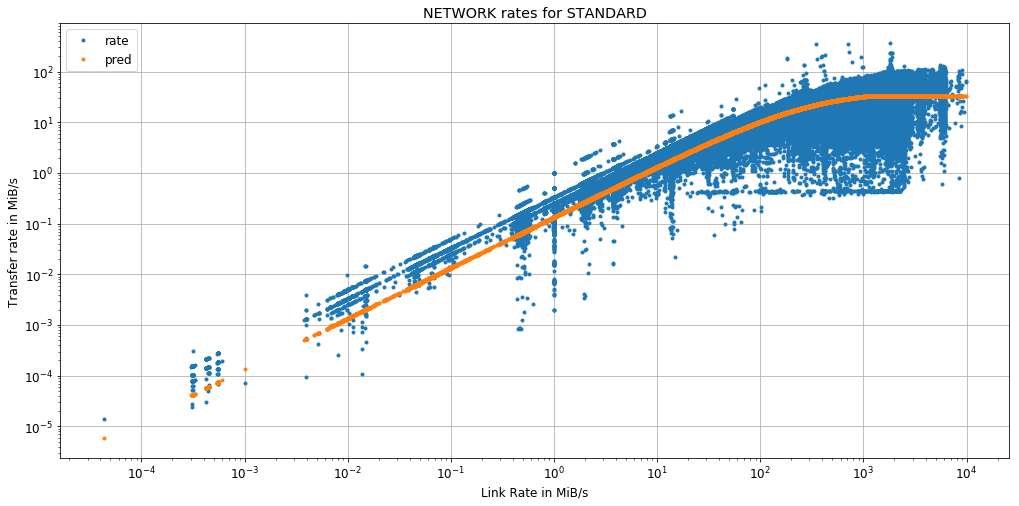

('STANDARD', 0.50525543970419151, 14391805.589544617, 3099, 44262580.268243894, 7.4124069285080871, 34840023.975300744)


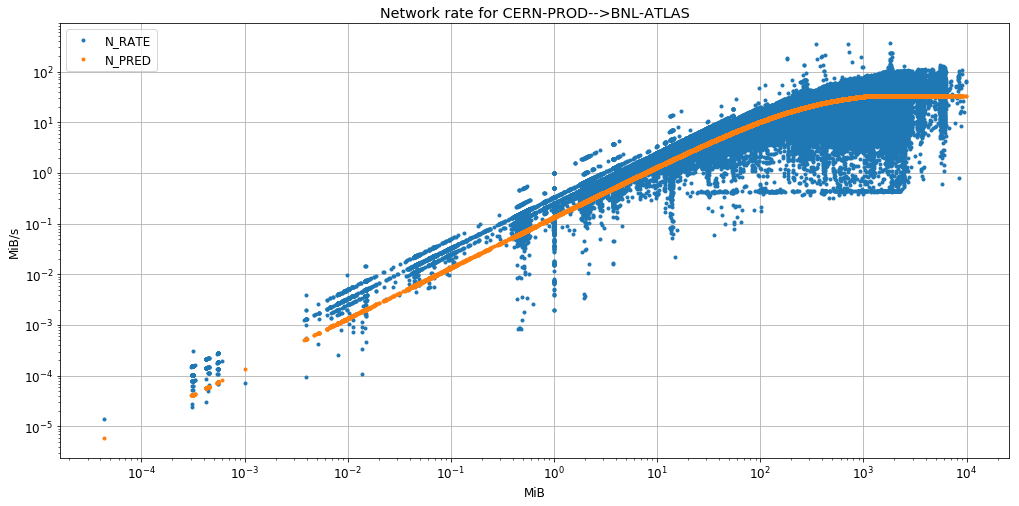

In [21]:
link = 'CERN-PROD__BNL-ATLAS'
data = get_data(link.split('__')[0],link.split('__')[1])
out = get_model('STANDARD',data, show=True)
plt.plot(data.SIZE/2**20,data.N_RATE/(1024*1024),'.')
plt.plot(data.SIZE/2**20,data.N_PRED/(1024*1024),'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MiB')
plt.ylabel('MiB/s')
plt.title('Network rate for %s'%link.replace('__','-->'))
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
#print ('MAE:%.02f R²:%.02f'%(mae(cut.N_TIME/(1024*1024), cut.NLFIT/(1024*1024)),r2(cut.N_TIME, cut.NLFIT)))
print(out)
plt.show()

In [ ]:
def test_model(link, data, model=model, overh_init=0.1, diskrw_init=100., show=False):
    cut = data.where(data.LINK == link).dropna()
    cut.N_RATE[cut.N_RATE == np.inf] = np.nan
    cut = cut.dropna()
    #cut = cut.where(cut.SIZE > 0).dropna()
    #cut = cut.where(cut.N_RATE > 0).dropna()
    if link not in model.LINK.values:
        print('WARNING: no model found for', link,maxindex)
        cut['N_PRED'] = [-np.inf]*len(cut)
    else:
        rate = model[model.LINK == link].RATE.values[0]
        overhead = model[model.LINK == link].OVERHEAD.values[0]
        diskrw = model[model.LINK == link].DISKRW.values[0]
        cut['N_PRED'] = cut.SIZE/((cut.SIZE/rate)+overhead)
        cut['N_PRED'][cut['N_PRED']>diskrw]=diskrw
    
    #vars = [cut.N_RATE.mean(), overh_init, diskrw_init]
    #vars = [cut.N_RATE.mean(), 0.1, 100.]
    #out = least_squares(objective, vars, args=(cut.SIZE, cut.N_RATE),bounds=(0,np.inf))
    #out = leastsq(objective, vars, args=(cut.SIZE, cut.N_RATE))
    #rate = out.x[0]
    #overhead = out.x[1]
    #diskrw = out.x[2] 
    #print(link,out)
    #cut['N_PRED2'] = cut.SIZE/((cut.SIZE/rate)+overhead)
    #cut['N_PRED2'][cut['N_PRED2']>diskrw]=diskrw
    try:
        r2score = r2(cut.N_RATE,cut.N_PRED)
        rmse = np.sqrt(mse(cut.N_RATE,cut.N_PRED))
    except ValueError:
        r2score = -np.Inf
        rmse = np.Inf
    #try:
    #    r2score2 = r2(cut.N_RATE,cut.N_PRED2)
    #    rmse2 = np.sqrt(mse(cut.N_RATE,cut.N_PRED2))
    #except ValueError:
    #    r2score2 = -np.Inf
    #    rmse2 = np.Inf
    datalen = len(cut)
    if show:
        cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
        plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
        plt.plot(cut.SIZE/(1024*1024), cut.N_PRED/(1024*1024),'.', label='pred')
        #plt.plot(cut.SIZE/(1024*1024), cut.N_PRED2/(1024*1024),'.', label='pred new')
        plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Link Rate in MiB/s')
        plt.xlabel('Transfer size MiB')

        fig = plt.gcf()
        fig.set_size_inches(17, 8)
        plt.legend()
        plt.grid()
        #print ('RMSE:%.02f R²:%.02f'%(rmse,r2score))
        plt.show()
    return r2score, rmse, datalen, rate, overhead, diskrw#, r2score2, rmse2

In [ ]:
#link = 'BNL-ATLAS__TOKYO-LCG2'
link = 'CERN-PROD__BNL-ATLAS'
#link = 'BNL-ATLAS__CERN-PROD'
#link = 'RAL-LCG2__CSCS-LCG2'
#link = 'FZK-LCG2__SWT2_CPB'
#link = 'SARA-MATRIX__ru-PNPI'
#link = 'BNL-ATLAS__CA-MCGILL-CLUMEQ-T2'
#link = 'Taiwan-LCG2__SiGNET'
#link =  'UNI-FREIBURG__BNL-ATLAS'
#link = 'UKI-SCOTGRID-GLASGOW__Taiwan-LCG2'
#link = 'WT2__BNL-ATLAS'
#link =  'RRC-KI-T1__RAL-LCG2'
#link = 'IFIC-LCG2__INFN-T1'
#link = 'RAL-LCG2__CSCS-LCG2'
cut = data.where(data.LINK == link).dropna()
cut.N_RATE[cut.N_RATE == np.inf] = cut.SIZE
plt.plot(cut.SIZE/(1024*1024), cut.N_RATE/(1024*1024),'.', label='rate')
plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Link Rate in MiB/s')
plt.xlabel('Transfer size MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()
plt.hist(cut.N_RATE,bins=100)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#link = 'BNL-ATLAS__TOKYO-LCG2'
first = cut[cut.SIZE < 10**6]
p1 = np.polyfit(first.SIZE, first.N_RATE,1)
p1 = np.poly1d(p1)
secnd = cut[cut.SIZE > 10**7]
p2 = np.polyfit(secnd.SIZE, secnd.N_RATE,1)
p2 = np.poly1d(p2)
oini=max(0.01,1/p1.coeffs[0])
dini=max(0.01,1/p2.coeffs[0])
print('Initialization: overhead=%f  diskrw=%f'%(oini, dini))
r_2,rmse,datalen, rate,over,disk= test_model(link, data,model2,overh_init=oini,diskrw_init=dini, show=True)
print('r2:   ', r_2)
print('rmse: ', rmse/(1024*1024))
print('rate: ', rate/(1024*1024))
print('overh:', over)
print('disk: ', disk/(1024*1024))
#print('r2.2: ', r_22)
#print('rmse2:', rmse2/(1024*1024))

In [ ]:
d = {}
for v in cut.itertuples():
    if v.SRC+'__'+v.DST not in d.keys():
        d[v.SRC+'__'+v.DST] = []
    d[v.SRC+'__'+v.DST].append([v.SIZE, v.N_RATE])

for k in d:
    d[k] = np.array(d[k]).T


In [ ]:
for k in d:
    plt.plot(d[k][0]/(1024*1024), d[k][1]/(1024*1024),'.', label=(k+'('+str(len(d[k][0]))+')'),alpha=0.9)
plt.title('NETWORK rates for %s'%link.replace('__', '-->'))
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Link Rate in MiB/s')
plt.xlabel('Transfer size MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
for k in d:
    x = '%0.2f, %0.2f, %d, %s' %(d[k][1].mean()/(1024*1024),d[k][1].std()/(1024*1024), len(d[k][0]), k)
    print (x)

In [ ]:
for k in d:
    #plt.hist(d[k][1]/(1024*1024),bins=100, alpha=0.9)
    plt.plot(d[k][0]/(1024*1024), d[k][1]/(1024*1024),'.', label=(k+'('+str(len(d[k][0]))+')'),alpha=0.9)
    plt.title('NETWORK rates for %s'%k.replace('__', '-->'))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Link Rate in MiB/s')
    plt.xlabel('Transfer size MiB')
    fig = plt.gcf()
    fig.set_size_inches(17, 8)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
model2.corr()

In [ ]:
plt.plot(model2.RATE[model2.RATE > -np.inf]/(1024*1024),
         model2.DISKRW[model2.DISKRW > -np.inf]/(1024*1024),
         #model2.OVERHEAD[model2.OVERHEAD > -np.inf],
         '.', alpha=0.9)
#plt.title('NETWORK rates for %s'%k.replace('__', '-->'))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rate in MiB/s')
plt.ylabel('Disk r/w limit MiB')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.hist(model2.RATE[model2.RATE > -np.inf][model2.RATE < 10**9]/(1024*1024),bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('MiB/s')
#lt.xlim((0,100))
plt.title('RATE')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(model2.OVERHEAD[model2.OVERHEAD > -np.inf],bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.title('OVERHEAD')
plt.xlabel('seconds')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(model2.DISKRW[model2.DISKRW > -np.inf]/(1024*1024),bins=100, alpha=0.95)
fig = plt.gcf()
#plt.xscale('log')
plt.yscale('log')
plt.title('DISKRW')
plt.xlabel('MiB/s')
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()